# AM207 Final Project

#### Team: ShiLe Wong, Xin Zeng (interested in research), Yujie Cai, Jiahui Tang

#### Paper: Risk score learning for COVID-19 contact tracing apps

# Notebook contents

⛔ PLEASE DO NOT RERUN THE EXPERIMENT PART (II.4) SINCE IT TAKES EXTREMELY LONG TIME

If you need to return to the content page, kindly press `return to top` in each section.

[I. Introduction](#I.-Introduction)

 - [Problem Statement](#Problem-Statement)
 
 - [Literature](#Literature)
 
[II. Methods](#II.-Methods)

 - [1. High Level Technical Content](#1.-High-Level-Technical-Content)
 
 - [2. Detailed Technical Content](#2.-Detailed-Technical-Content)
 
  - [2.1 Synthetic data generator](#2.1-Synthetic-data-generator)
  
  - [2.2 Machine learning technique used](#2.2-Machine-learning-technique-used)
  
 - [3. Implementation](#3.-Implementation)
 
  - [A. Simulation of Toy Dataset](#A.-Simulation-of-Toy-Dataset)
  
  - [B. Bagging Simulator](#B.-Bagging-Simulator)
  
  - [C. Training the Model](#C.-Training-the-Model)
  
       - [Analytical Gradient](#Analytical-Gradient)
   
       - [Training Code](#Training-Code)
       
 - [4. Model and Experiments](#4.-Model-and-Experiments)
  
  - [1. Varying maximum bag size](#1.-Varying-maximum-bag-size)
   
  - [2. Varying censoring probability](#2.-Varying-censoring-probability)
  
  - [3. Varying Positive Bag Construction](#3.-Varying-Positive-Bag-Construction)
  
  - [4. Robustness to Model Mismatch](#4.-Robustness-to-Model-Mismatch)
  
  - [5. Reordering of data](#5.-Reordering-of-data)
  
  - [6. Examples of failure mode](#6.-Examples-of-failure-mode)
  
[III. Discussion](#III.-Discussion)

 - [1. Evaluation](#1.-Evaluation)
 
 - [2. Future Work and Potential Modifications](#2.-Future-Work-and-Potential-Modifications)
 
 - [3. Broader Impact](#3.-Broader-Impact)
 
[References](#References)


# I. Introduction

* Problem statement - what is the problem the paper aims to solve?
* Context/scope - why is this problem important or interesting?
* Existing work - what has been done in literature?
* Contribution - what is gap in literature that the paper is trying to fill? What is the unique contribution


### **Problem Statement**

During the COVID-19 Pandemic, contact tracing came to the forefront of digital tools to help combat the spread of the virus. Part of the work in contact tracing is to accurately determine the risk of infection of an individual given their exposure to other individuals who have tested positive, so as to alert the individual should the risk be significant. This paper aims to solve the problem of accurately determining the probability of infection based on features of interpersonal interactions (e.g. duration and distance of interaction) and the contagiousness of the infected case.

This is particularly important since contact tracing is a key tool used by many places to contain the spread of the virus. When an individual is alerted of their risk of infection in a timely manner, they can be advised to isolate and thereby reduce the chances of them spreading the virus to other people should they be infected. Hence, accurately determining the risk of infection and using the information to advise individuals of relevant protocols can determine the efficacy of contact tracing as a tool, and more seriously, the extent of virus and pandemic progression.

### **Literature**

[Return to top](#Notebook-contents)

The paper references a few examples of work that has been done in contact tracing, and specifically in using data to train models for risk scoring. First, the paper centers on the risk score model for the Google/Apple Exposure Notification (GAEN) system [1] for contact tracing, which has predefined relationships of specified parameters that come from data which can be collected through mobile applications. The associated parameters are the main focus of the machine learning optimization problem covered in the paper, and that we hope to recreate.

Second, the paper highlights that many current risk score models or contact tracing apps assume a known model with fixed parameters. There is a publicly available resource put together by domain experts that suggest values for the parameters. [2] A couple of other papers cited also evaluate the effectiveness of contact tracing apps that assume a fixed, known model. [3,4] The authors find this landscape to present a gap in that these models are not dynamic or flexible enough to adjust to or reflect what the data might tell us. Having fixed parameters beforehand without accounting for what is happening in real life (as seen from data), even if they were determined through expert guidance, may still be biased or inaccurate. Hence, they suggest that their own model of training to fit data could perform better at estimating an individual's risk of infection, and compare their results to that of a Swiss model that uses fixed thresholds. [5]

Finally, they acknowledge one paper that attempts to use data to train a model that optimizes for the risk parameters. [6] However, there were two gaps: (1) this earlier paper did not account for the infectiousness of the index case; and (2) this earlier paper performed supervised learning. For the first gap, by not accounting for the infectiousness, the model is potentially missing out on additional useful data that could inform the risk score, since the infectiousness of a patient you come across could greatly affect whether or not you would catch the virus from them. Moreover, the infectiousness is data that is captured by the GAEN app, so having a model that can utilize all the relevant data points collected by the app can maximize its efficacy and allow the model to be deployed directly. The second gap relates to the real-life applicability of the model. This current paper suggests that they have a better solution since their model takes into account imperfect information, for example, by not having complete infection labels for every single exposure, but an overall label for a bag of exposures that is prone to false negatives because of censoring. This is also potentially more realistic in a real-life situation where information collection is likely imperfect.

# II. Methods

## 1. High Level Technical Content 

[Return to top](#Notebook-contents)

Due to privacy issues, the authors of the paper could not access real data collected by the covid tracing app. Therefore, the first contribution they made was to propose a mechanism to generate synthetic data, which we will provide detailed documentation of in II.2. Since the focus of our project is on understanding and testing their model for learning risk score parameters, we have decided to use the same synthetic data generator to replicate and test the experiments. 

Second, with a dataset in hand, the authors performed several comparative experiments to prove that their algorithm is effective in estimating parameters of risk score models. They do this by doing a semi-supervised machine learning, where observations are clustered or "bagged" and their labels are aggregated (and in some cases, partially censored). The observation features are then fed into a machine learning model for the model to learn to predict risk scores that will maximize the log-likelihood of the corresponding bag labels. Producing risk score estimations involves optimizing for parameters such as attenuation thresholds and weights and contagiousness weights, which was performed using the `jax` package implementation of stochastic gradient descent.


## 2. Detailed Technical Content

[Return to top](#Notebook-contents)

### 2.1 Synthetic data generator:


Although data generation is not the main objective of this project, it is worth pointing out that the authors have done a tremendous job putting together a sensible physical model using scientific literature, and coming up with approximation tools to simulate the real life scenario, i.e. the transmission mechanism of COVID-19. We will elaborate on how the transmission is modelled in the physical world and analogous features collected on the mobile application, since this is what defines the generative model and is thus used to inform the eventual optimization.

A bottom-up approach can be used to describe the transmission mechanism. That is, we first figure out the risk of infection from a single exposure, then we combine it with the social network effect to determine how aggregated exposures may have an effect on a person's overall infection outcome.

#### **2.1.1 In the real world: Biological Model of Risk Scoring**


Suppose a person is exposed to another person who has been infected. The hazard score of that event is defined to be a function of three arguments: duration of exposure $\tau_n$, the distance of exposure $d_n$, and the time of sympton onset since the exposure $\sigma_n$ (of the infected person), which is a proxy for the infectiousness of the index case. Namely, 

$$s_n = f(\tau_n, d_n, \sigma_n; \phi) = \tau_n \times f_{dist}(d_n; \phi) \times f_{inf}(\sigma_n; \phi) \quad \quad (1)$$

where $\phi$ are parameters of the simulator. Notice the exact functional form of $f_{dist}$ and $f_{inf}$ follow fluid physics law as well as empirical conventions[1,2], which we choose not to write in details here given this is not our core implementation and innovation. 


#### **2.1.2 On a mobile application: Translating the biological model to a computational model**

> ##### **From Hazard Score to Risk Score**

Since all training features (essentially the model inputs) will be recorded by a mobile device, the data generator is modelled after the device used for recording. For this paper, the authors decide to follow the GAEN system as mentioned above in the Introduction. Specifically, the distance function $f_{dist}$ is approximated by bluetooth attentuation $f_{ble}$, and the infectiousness calculation function $f_{inf}$ is approximated by a quantized version of symptom onset time $f_{con}$. Rewriting equation (1) from above, we get the risk score model:

$$r_n = f(\tau_n, a_n, c_n; \psi) = \tau_n \times f_{ble}(a_n; \psi) \times f_{con}(c_n; \psi)  \quad \quad (2)$$

where $\psi$ are parameters of the risk score model. The inputs to the model that are proxied by digital features are elaborated on below.

> ##### **Distance as proxied by Bluetooth Attenuation**

The bluetooth attenuation function assigns different weights to different attenuation thresholds, and all the weights and thresholds are parameters to optimize for. To put it simply, the farther apart the devices, the less weight the attenuation function assigns. The actual math shows a relationship that maps bluetooth attenuation ($a_n$) to 4 categories defined by 3 attentuation threshold angles, $\theta_b^\text{ble}$ (distance), with each category having an output of one weight. 

\begin{equation*}
f_{\text{ble}}(a_n; \psi)=\begin{cases}
          w_1^\text{ble} \quad &\text{if} \, a_n \leq \theta_1^\text{ble} \\
          w_2^\text{ble} \quad &\text{if} \, \theta_1^\text{ble} < a_n \leq \theta_2^\text{ble} \\
          w_3^\text{ble} \quad &\text{if} \, \theta_2^\text{ble} < a_n \leq \theta_3^\text{ble} \\
          w_4^\text{ble} \quad &\text{if} \, \theta_3^\text{ble} < a_n \\
     \end{cases}
\end{equation*}

Two modifications to this mapping function that is relevant for our work is (1) the assumption of monotocity of the weights; and (2) transforming this discretized categorization into a continuous function. These two modifications directly influence our mathematical work and interpretation.

(1) Assumption of Monotonicity

Biologically, it is reasonable to believe that the risk of infection only gets higher when the distance between an individual and infected case gets closer. Hence, to ensure this monotonic relationship is followed in the computational model, the authors opted to reparameterize the weights as follows:

$$w^{\text{ble}} = [w_1^{\text{ble}}, w_2^{\text{ble}} = w_1^{\text{ble}} + \Delta_2^{\text{ble}}, w_3^{\text{ble}} = w_2^{\text{ble}} + \Delta_3^{\text{ble}}, w_4^{\text{ble}} = w_3^{\text{ble}} + \Delta_4^{\text{ble}}]$$
 
Hence, we will optimize over $(w^{\text{ble}}_1, \Delta_2^{\text{ble}},\Delta_3^{\text{ble}},\Delta_4^{\text{ble}})$ instead of $(w_1^{\text{ble}}, w_2^{\text{ble}}, w_3^{\text{ble}}, w_4^{\text{ble}})$. We will have a function that maps the weights to the parameters we optimize, and vice versa.

(2) Discrete to continuous mapping

The approach as represented by the function right now is known as hard binning. However, this means that the function is not continuous with respects to the attenuation thresholds. The motivation to ensure the function is continuous with respects to the thresholds is so that the function can be easily differentiated with respects to the thresholds and thus the gradient can be easily calculated too. Hence, the authors opted to replace this hard binning method with a soft thresholding approximation, by converting the discrete mapping to one that utilizes the sigmoid function, $\sigma_\tau$. In the equations below, $I \left(\theta^{\text{ble}}_{b-1} < a_{nk} \leq \theta^{\text{ble}}_{b}\right)$ represents the output from the discrete function presented above.

\begin{aligned}
\tau_{nb} &= \sum_k \tau_{nk} I \left(\theta^{\text{ble}}_{b-1} < a_{nk} \leq \theta^{\text{ble}}_{b}\right)\\
& \approx \sum_k \tau_{nk} \sigma_\tau (a_{nk} - \theta^{\text{ble}}_{b-1}) \sigma_\tau(\theta^{\text{ble}}_{b}-a_{nk})\\
& \approx \sum_k \tau_{nk} \left[\frac{1}{1+\exp(-t(a_{nk} - \theta^{\text{ble}}_{b-1}))}\right] \left[\frac{1}{1+\exp(-t(\theta^{\text{ble}}_{b}-a_{nk}))}\right]\\
\end{aligned}

> ##### **Contagiousness of Index Case**

The days since symptom onset is calculated by health authorities and directly mapped to 3 contagiousness levels: none ($c_n = 1$), standard ($c_n = 2$), and high ($c_n = 3$). The eventual contagiousness level is then used in the risk scoring instead of having the calculated days be directly accessible by Google/Apple in view of privacy concerns. Again, zero weight is assigned to the none level, and two non-zero weights are assigned to the other two levels. 

\begin{equation*}
f_{\text{con}}(c_n; \psi)=\begin{cases}
          0 \quad &\text{if} \, c_n = 1 \\
          w_2^{\text{con}} \quad &\text{if} \, c_n = 2 \\
          w_3^{\text{con}} \quad &\text{if} \, c_n = 3 \\
     \end{cases}
\end{equation*}

Again, there is an assumption of monotonicity that is used to reparameterize the weights because there is a biological basis for believing that the risk of infection will only increase with increasing contagiousness.

$$w^{\text{con}} = [w_2^{\text{con}}, w_2^{\text{con}} + \Delta^\text{con}]$$

We will optimize over $(w_2^{\text{con}}, \Delta^\text{con})$ and similarly have a function that maps between these parameters and the weights in the function.

> ##### **Mapping Risk Score to Probability of Infection**

Finally, to map the risk score into probability space, which is constrained to the bounds $[0,1]$, the authors use the standard exponential does response model [3]. Below is the form that uses the risk score model (instead of the hazard score model), which takes into account the digital features collected to determine the estimated probability of infection. 

$$q_n = \mathbb{P}(y_n = 1|\tilde x_n; \psi) = 1 - e^{-\mu r_n}$$

Here $\tilde x_n = (\tau_n, a_n, c_n)$, $y_n = 1$ (infected) or $0$ (not infected).

#### **2.1.3 Multiple exposures**

As an extension of the individual exposure modelling described above, the authors look at combining the risk from multiple exposures to reflect a single individual's experience, First, the authors recognize that different exposure events means different lengths of time spent in different distances to infected cases. This is represented by calculating the amount of time spent in each attenuation bucket (which is then transformed to the continuous sigmoid):

$$\underbrace{\tau_{n b}}_{\text{duration in bucket } b}= \sum_{k=1}^{K_{n}} \underbrace{\tau_{n k}}_{\text {duration}} \times \underbrace{\mathbb{I}\left(\theta_{b-1}^{\text {ble }}< a_{nk} \leq \theta_{b}^{\text {ble}}\right)}_{\text{attenuation is in bucket } b}$$

where $K_n$ is the number of exposures within the n'th exposure window. We then are able to compute the overall risk for the exposure:

$$\underbrace{r_{n}}_{\text {risk score }}=\underbrace{\left[\sum_{b=1}^{N_{B}} \tau_{n b} w_{b}^{\text {ble }}\right]}_{\text {weighted exposure minutes }} \times \underbrace{\left[\sum_{\ell=1}^{N_{C}} \mathbb{I}\left(c_{n, \ell}\right) w_{\ell}^{\text {con }}\right]}_{\text {weighted contagiousness level }}$$

If we have multiple exposures for a user, we sum the risk scores to get $R_j = \sum_{n \in E_j} r_n$, which then translates into an overall probability of infection:

$$Q_j = 1 - e^{-\mu \cdot R_j}$$

#### **2.1.4 Bagging of exposure observations**

The individual exposure events are first randomly generated. Then, the exposure events are randomly grouped or bagged to represent the experience of an individual, and the probability of infection is calculated using the above aggregation. Each exposure event can affect multiple individuals, in a concept coined as the social network effect in the paper. However, this is not crucial to our calculations since it is taken care of in the bagging step of the model instead of in optimization. The probability of infection is then used to generate the ground truth label of whether a person is infected or not.

Having generated the data, the authors attempt to simulate the situation on the other side, which is in receiving the data and optimizing a model for the parameters. The same model is assumed for optimization, and the bagging of exposure events as described in the section above adds complexity in terms of noise and the potential for "censoring", where determinative exposure events (when an exposure significantly contributes to a person's risk but is not recorded) is not captured.


### 2.2 Machine learning technique used

 + Multi-instance learning, Stochastic Gradient Descent

The paper is dealing with a multi-instance (MI) learning problem, which belongs to supervised learning. Where MI learning differs from the traditional scenario is in the nature of the learning examples. In MI learning each example is represented by a bag of feature vectors. Classification labels are only provided for entire bags, and the task is to learn a model that predicts the classification labels for unseen future bags. In our case, we have only one, binary label (a user gets infected or not) for a "bag" of exposure events. Potentially this type of problem gets more challenging to tackle as the bag getting larger or the feature in the bag is noisy, which correspond to more exposures and censoring recorded on the app. 


As mentioned above, we have ten parameters of the infectious risk model to learn. To recap, two weights parameters $(\Delta_{2:3}^{\text{con}})$ come from the contageousness measure; three threshold angles $(\theta_{1:3}^{\text{ble}})$ and four weights $(w_1^{\text{ble}} \text{and} \Delta_{2:4}^{\text{ble}})$ from bluetooth attentuation; and $\mu$, a constant in the exponential model. The objective is to maximize the log-likelihood (or minimizing the binary cross entropy) of th e following fuction, where $Q_j$ incorporates these parameters:

$$\mathcal{L}(\psi) = -\sum_{j=1}^J Y_j \log Q_j + (1-Y_j)\log (1-Q_j)$$

$Y_j \in \{0,1\}$ is the infection label for user $j$. 

The exact techniques used by original authors are not complicated though, since relatively simple algorithm such as stochastic gradient descent (SGD) has proven the effectivness through their experiments. Gradient descent is an iterative algorithm, that starts from a random point on a function and travels down its slope in steps until it reaches the optimal point of function. Adding stochastic component can let the gradient descent to start at random point for each iteration. Some biggest advantages are to reduce the computations enormously and to avoid the algorithm stuck at undesired optima. However, we need to be careful on choosing a proper learning rate, as SGD is sensitive to it. 

In the original experiment, the authors fit the model using 1000 iterations with batch size of 100. After the fitting, they choose AUC as metrics to discusses the performance with increasing problem complexity. 


## 3. Implementation

[Return to top](#Notebook-contents)

There are 3 parts to the implementation: (A) Data Simulation and Generation, (B) Bagging Simulation, and (C) Learning Model Training. As mentioned, we have decided to use the original data simulation and generation code, as well as most of the bagging simulation, since the focus of our project is on testing the learning model. We have modified the original code to simplify processes where possible and to use simpler python functions as a way to test the robustness of the algorithm when reduced to less fancy functions.

In [1]:
# it is advisory to install this version of jax package, and to run the notebook on intel-chip computer
# !pip install jax==0.2.18

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import math
import itertools
import numpy as np
from scipy.stats import nbinom
from functools import partial
import scipy.stats
from scipy.stats import bernoulli
from dataclasses import dataclass, asdict
import sklearn.metrics as metrics
from textwrap import wrap
import random
from sklearn.model_selection import train_test_split

import jax
import jax.numpy as jnp
import jax.nn as jnn

### A. Simulation of Toy Dataset

The end goal of the simulation is to create a set of data points that have the features used to train the model (e.g. bluetooth attenuation, infectiousness, etc.), the labels for the data points (whether the exposure led to an infection) and the probability of infection, as calculated using the generative model and parameters. The code first includes a few helper functions for calculating different components of the risk score. Then we put it in a dictionary and calculate the probabilities and labels for subsequent use.

In [3]:
### Original Data Generating Function

@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float = 2.398
  name: str = 'briers-lognormal'

@dataclass
class ModelParams:
  ble_params: BleParams = BleParams()  # may want to change sigma
  distance_fun: str = 'quadratic'  # quadratic  or sigmoid
  distance_Dmin: float = 1.0
  distance_slope: float = 2.0
  distance_inflection: float = 2.0
  infectiousness_fun: str = 'skew-logistic'  # gaussian or skew-logistic
  beta: float = 1e-1  # transmission rate (the simulation Colab uses 1e-3)

@dataclass
class RiskConfig:
    ble_thresholds: jnp.array  = jnp.array([])
    ble_weights: jnp.array  = jnp.array([])
    inf_levels: jnp.array  = jnp.array([])
    inf_weights: jnp.array  = jnp.array([])
    name: str = ''
    beta: float = 3.1 * 1e-6  # Wilson table 1


def incubation_dist(t):
  mu = 1.621
  sig = 0.418
  rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
  return rv.pdf(t)

# Symptom days to infectiousness
def skew_logistic_scaled(x, alpha, mu, sigma):
  return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)

def ptost_conditional(ts, incubation):
  mu = -4
  sigma = 1.85
  alpha = 5.85
  tau = 5.42
  fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
  fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
  ps = fpos
  neg = jnp.where(ts < 0)
  ps[neg] = fneg[neg]
  ps = ps/np.max(ps)
  return ps

def ptost_uncond(tost_times):
  incub_times = np.arange(1, 14, 1)
  incub_probs = incubation_dist(incub_times) 
  tost_probs = np.zeros_like(tost_times, dtype=float)
  for k, incub in enumerate(incub_times):
    ps = ptost_conditional(tost_times, incub)
    tost_probs += incub_probs[k] * ps
  return tost_probs

infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)

def infectiousness_skew_logistic(delta):
  return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)

# Distance to dose
def transmission_vs_distance_quadratic(d, Dmin=1):  
  m = np.power(Dmin,2)/np.power(d, 2)
  return np.minimum(1, m)

# Generating input data grid
def uniform_input_data_grid(max_dur = 60, max_dist = 5, ngrid_dist = 20, ngrid_dur=20, min_dist=0.1, min_dur=5):
  distances = np.linspace(min_dist, max_dist, ngrid_dist) # meters
  durations = np.linspace(min_dur, max_dur, ngrid_dur) # minutes
  symptoms = np.arange(-10, 10+0.001, dtype=int) # must be int
  return distances, durations, symptoms

# Generating input data and parameters
def make_input_data(sigma=0.1, nsamples=20, distances=None, durations=None, symptoms=None):
  if distances is None:
    distances, durations, symptoms = uniform_input_data_grid()
  ble_params = BleParams()
  attens = dist_to_atten(distances, ble_params)
   
  # Make 3d cross product of the three 1d inputs
  vals = itertools.product(distances, durations, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  distance_grid = X[:,0]
  duration_grid = X[:,1]
  symptom_grid = np.array(X[:,2], dtype=int)
  n = len(distance_grid)
  print('Making grid of {} distances x {} durations x {} onsets = {} points'.format(
      len(distances), len(durations), len(symptoms), n))

  # noise-free atteniations  
  atten_grid = dist_to_atten(distance_grid, ble_params) 

  # noisy samples
  atten_grid_samples = []
  for n in range(nsamples):
    sample = dist_to_atten_sample(distance_grid, ble_params, sigma)
    atten_grid_samples.append(sample)

  
  # Make 2d matrix for surface plotting functions (for fixed duration)
  grid_2d_matrix = np.meshgrid(symptoms, attens)
  symptom_grid_2d_matrix, atten_grid_2d_matrix  = grid_2d_matrix
  vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
  X = np.vstack([np.array(v) for v in vals])
  symptom_grid_2d = np.array(X[:,0], dtype=int)
  atten_grid_2d = X[:,1]

  data = {
          'distance_grid': distance_grid, 'atten_grid': atten_grid, 
          'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
          'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
          'atten_grid_2d_matrix': atten_grid_2d_matrix,
          'symptom_grid_2d': symptom_grid_2d,
          'atten_grid_2d': atten_grid_2d,
          'atten_grid_samples': atten_grid_samples,
          'noise_level': sigma, 'nsamples': nsamples}
  return data


# Transmission model
def hazard_fun_batch(attenuations, durations, symptom_days, params, distances=None):
  """
  Args:
    params = ModelParams() object.
  """
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
  elif params.distance_fun == 'sigmoid':
    fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
  elif params.distance_fun == 'spline':
    fd = transmission_vs_distance_spline(distances)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days) 
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf 
  return doses

# calculate probability of infection, with option to do an approx with Taylor series
def prob_infection_batch(attenuations, durations, symptom_days, params, approx='taylor', exp_taylor_terms=np.inf, temp=1, distances=None):
  """
  Args:
    params = ModelParams() object.
  """
  doses = hazard_fun_batch(attenuations, durations, symptom_days, params, distances)
  prob_infect_exact = 1-np.exp(-params.beta * doses)
  if not (isinstance(temp, list) or isinstance(temp, np.ndarray)):
    temp = list(temp)

  if approx == 'none' or (approx == 'taylor' and exp_taylor_terms == np.inf) or (approx == 'tempered' and len(temp)==1 and temp[0] == 1):
    prob_infect_approx = prob_infect_exact
  elif approx == 'taylor' and exp_taylor_terms < np.inf:    
    prob_infect_approx = []
    x = -params.beta * doses
    prob_infect = np.zeros(len(doses))
    for k in range(1,exp_taylor_terms+1):
      prob_infect -= x**k / math.factorial(k)
      prob_infect_approx.append(np.minimum(np.maximum(prob_infect, 0), 1))
  elif approx == 'tempered':
    prob_infect_approx = []
    x = -params.beta * doses
    for t in temp:
      prob_infect = 1 - np.power(np.maximum(1 + (1-t)*x,0), 1/(1-t))
      prob_infect_approx.append(prob_infect)
  else:
    raise ValueError("Unknnown approximation type: {}".format(approx))
  return prob_infect_exact, prob_infect_approx


def prob_infection_grid(data, params, approx='none', exp_taylor_terms=np.inf, temp=1):
  """
  Args:
    data = dictionary obtained from make_input_data().
    params = ModelParams() object.
    approx: Approximation for the exponential function for simulating model mismatch (none/taylor/tempered)
    exp_taylor_terms: Number of approximation terms to use for Taylor approximation
    temp: Array of temperature parameters for 'tempered' approximation 
  """
  ps = prob_infection_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], params, approx, exp_taylor_terms, temp)
  return ps

def risk_score_grid(data, config):
  rs = risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return rs

def prob_risk_score_grid(data, config):
  qs = prob_risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return qs

def risk_score_grid_sample(data, config, ndx):
  rs = risk_score_batch(data['atten_grid_samples'][ndx], data['duration_grid'], data['symptom_grid'], config)
  return rs

def atten_to_rssi(atten, ble_params):
  return ble_params.tx  - (atten + ble_params.correction)

def rssi_to_atten(rssi, ble_params):
  return ble_params.tx - (rssi + ble_params.correction)

def atten_to_dist(atten, ble_params):
  rssi = ble_params.tx  - (atten + ble_params.correction)
  return np.exp((np.log(-rssi) - ble_params.intercept)/ble_params.slope)

def dist_to_atten(distance, ble_params):
  mu = ble_params.intercept + ble_params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = ble_params.tx  - (rssi + ble_params.correction)
  return atten

# This will be used in the future to add noise
def dist_to_atten_sample(distances, ble_params, sigma):
  # if ble_params.sigma == 0:
  if sigma == 0:
    return dist_to_atten(distances, ble_params)
  N = len(distances)
  mus = ble_params.intercept + ble_params.slope * np.log(distances)
  # sigs = ble_params.sigma
  sigs = sigma
  rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
  atten = ble_params.tx  - (rssi + ble_params.correction)
  return atten

def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights

def days_to_inf_levels(symptom_days):
  symptom_days = np.atleast_1d(symptom_days)  # turn into array
  inf_levels, _ = make_infectiousness_params_v2()
  return inf_levels[symptom_days + 14]

# initializing input data
distances, durations, symptoms = uniform_input_data_grid(max_dur = 60,  max_dist = 5, ngrid_dist = 80, ngrid_dur=20, min_dist=0.1, min_dur=5)
data = make_input_data(distances=distances, durations=durations, symptoms=symptoms)

# initializing parameters
ble_params = BleParams()
rssi = atten_to_rssi(data['atten_grid'], ble_params)
duration = data['duration_grid']
symptom_day = data['symptom_grid']
infectiousness = days_to_inf_levels(symptom_day)

params = ModelParams()

# Create model inputs
X = np.concatenate([rssi[:,None], duration[:,None], infectiousness[:,None]], axis=1)
approx_type = 'taylor'
exp_taylor_terms = 8
exp_temperature = np.arange(0.5,1.,0.09)

# calculating probability of infection
prob_infect_exact, prob_infect_approx = prob_infection_grid(data, params, approx=approx_type, exp_taylor_terms=exp_taylor_terms, temp=exp_temperature)
prob_infect_approx = np.array(prob_infect_approx)
# manually inspect the approximation error (higher error for larger values -- away from 0)
ind = np.where(prob_infect_exact>0.6)
print('Approx:', prob_infect_approx[:,ind])
print('Exact:', prob_infect_exact[ind])


print (X.shape, prob_infect_exact.shape)


simdata = dict()
simdata['X'] = X
simdata['prob_infect_exact'] = prob_infect_exact
simdata['prob_infect_approx'] = prob_infect_approx


Making grid of 80 distances x 20 durations x 21 onsets = 33600 points
Approx: [[[1.         1.         1.         ... 0.97538178 0.92937435 0.92675691]]

 [[0.49996063 0.49998181 0.46092688 ... 0.49969697 0.49750601 0.49731772]]

 [[0.67110338 0.66968263 0.81008083 ... 0.65435507 0.63129513 0.62997964]]

 ...

 [[0.63518322 0.63414931 0.72087815 ... 0.62280329 0.60509304 0.60406036]]

 [[0.63539429 0.63435626 0.72199235 ... 0.62296994 0.60521186 0.60417686]]

 [[0.63536768 0.63433023 0.72181414 ... 0.62294962 0.60519806 0.60416337]]]
Exact: [0.63537038 0.63433287 0.72183658 ... 0.62295162 0.60519936 0.60416464]
(33600, 3) (33600,)


In [4]:
X_epi = simdata['X']  
probabilities_true_epi = simdata['prob_infect_exact']
probabilities_true_epi_approx = simdata['prob_infect_approx'].T  # N x num_approx_steps
N = len(probabilities_true_epi)
perm = np.random.permutation(N)
X_epi = X_epi[perm, :]
probabilities_true_epi = probabilities_true_epi[perm]
probabilities_true_epi_approx = np.clip(probabilities_true_epi_approx[perm,:], 1e-5, 1-1e-5)
  
# generating labels for the exposure events
def sample_labels(probabilities):
  Y = bernoulli.rvs(probabilities)
  N_pos = np.sum(Y)
  N_neg = np.sum(1-Y)
  print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))
  pos_neg_ratio= float(N_neg) / N_pos
  return Y, N_pos, N_neg, pos_neg_ratio

Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)

total: 33600, positives: 5383, negatives: 28217


In [5]:
simdata

{'X': array([[-31.07666234,   5.        ,   0.        ],
        [-31.07666234,   5.        ,   0.        ],
        [-31.07666234,   5.        ,   0.        ],
        ...,
        [-70.66723028,  60.        ,   1.        ],
        [-70.66723028,  60.        ,   1.        ],
        [-70.66723028,  60.        ,   0.        ]]),
 'prob_infect_exact': array([0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
        0.0021102 ]),
 'prob_infect_approx': array([[0.00123653, 0.00276669, 0.00596975, ..., 0.00618441, 0.00361772,
         0.00211243],
        [0.00123577, 0.00276287, 0.00595193, ..., 0.00616529, 0.00361118,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        ...,
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00

### B. Bagging Simulator

[Return to top](#Notebook-contents) 

Next, we need to bag the exposure events to tag them to an individual's aggregated risk of infection. The bagging simulator takes in parameters to determine the bag size, and various probabilities determining the makeup of the bag (e.g. number of positive and negative exposures, etc.).

In [6]:
class Bag_Simulator():
    def __init__(self, p_pos, r_pos, p_neg, r_neg, max_bag_size, censor_prob_pos, censor_prob_neg, max_pos_in_bag=3):
        self.p_pos = p_pos
        self.r_pos = r_pos
        self.p_neg = p_neg
        self.r_neg = r_neg
        self.max_bag_size = max_bag_size
        self.censor_prob_pos = censor_prob_pos
        self.censor_prob_neg = censor_prob_neg
        self.max_pos_in_bag = max_pos_in_bag

    @staticmethod
    def get_pos_neg_bag_sizes(bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos_Y, N_neg_Y,
                              max_pos_in_bag=1, N_pos_bags=None):

        if max_pos_in_bag > max(bag_sizes):
            raise ValueError("max_pos_in_bag needs to be less than or equal to bag_sizes")
        if N_pos_bags is None:
            raise ValueError("Please give an input for N_pos_bags")
        # start from N_pos_bag, each time decrease by 10, until we get the required number of
        # negative and positive bag, and return the data simulation result
        for N_pos_bags_temp in range(N_pos_bags, 0, -10):
            pos_bag_size_samples = np.random.choice(bag_sizes, size=N_pos_bags_temp, replace=True, p=pos_bag_size_probs)
            # sample uniformly in order to prepare for the implementation -
            # <each positive bag contains N positive exposures>
            pos_samples_per_bag = np.random.randint(low=1, high=max_pos_in_bag + 1, size=N_pos_bags_temp)
            N_pos_required = np.sum(pos_samples_per_bag)
            N_neg_bags = int(N_pos_bags_temp * N_neg_Y / N_pos_Y)
            neg_bag_size_samples = np.random.choice(bag_sizes, size=N_neg_bags, replace=True, p=neg_bag_size_probs)
            N_neg_required = np.sum(pos_bag_size_samples - pos_samples_per_bag) + np.sum(neg_bag_size_samples)
            if N_neg_required < N_neg_Y and N_pos_required < N_pos_Y:

                return pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags_temp, \
                       int(N_pos_bags_temp * pos_neg_ratio)

    @staticmethod
    def get_neg_bino_norm(k, n, p):
        temp_pmf = nbinom.pmf(k, n, p)

        return temp_pmf / np.sum(temp_pmf)

    @staticmethod
    def train_test_split_func(mat, labels, N_pos_bags, N_neg_bags, train_ratio=0.8, order=True):
        N_bags = N_pos_bags + N_neg_bags
        N_pos_trn = int(N_pos_bags * train_ratio)
        N_neg_trn = int(N_neg_bags * train_ratio)
        if order:
            # if order = True, we use the same data splitting function as the original codebase
            # it will keep the first 80% as training data and keep the rest 20% as test data
            ind_trn = list(np.arange(N_pos_trn)) + list(np.arange(N_pos_bags, N_pos_bags + N_neg_trn))
            ind_tst = list(np.arange(N_pos_trn, N_pos_bags)) + list(np.arange(N_pos_bags + N_neg_trn, N_bags))
            np.random.shuffle(ind_trn)
            np.random.shuffle(ind_tst)
            assign_mat_trn, assign_mat_tst = mat[ind_trn], mat[ind_tst]
            bag_labels_trn, bag_labels_tst = labels[ind_trn], labels[ind_tst]
        else:
            # if order = False, we use our own data splitting function, which would not keep the order
            # of train and test data splitting
            assign_mat_trn_part_1, assign_mat_tst_part_1, bag_labels_trn_part_1, bag_labels_tst_part_1\
                = train_test_split(mat[:N_pos_bags], labels[:N_pos_bags], train_size=train_ratio)
            assign_mat_trn_part_2, assign_mat_tst_part_2, bag_labels_trn_part_2, bag_labels_tst_part_2 \
                = train_test_split(mat[N_pos_bags:], labels[N_pos_bags:], train_size=train_ratio)
            assign_mat_trn = np.concatenate((assign_mat_trn_part_1, assign_mat_trn_part_2), axis=0)
            assign_mat_tst = np.concatenate((assign_mat_tst_part_1, assign_mat_tst_part_2), axis=0)
            bag_labels_trn = np.concatenate((bag_labels_trn_part_1, bag_labels_trn_part_2), axis=0)
            bag_labels_tst = np.concatenate((bag_labels_tst_part_1, bag_labels_tst_part_2), axis=0)
        # deal with the censoring issues - a user may get exposed to events that are not recorded by their phone
        bag_labels_trn = bag_labels_trn[np.sum(assign_mat_trn, axis=1) > 0]
        bag_labels_tst = bag_labels_tst[np.sum(assign_mat_tst, axis=1) > 0]
        assign_mat_trn = assign_mat_trn[np.sum(assign_mat_trn, axis=1) > 0, :]
        assign_mat_tst = assign_mat_tst[np.sum(assign_mat_tst, axis=1) > 0, :]

        return assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst

    def simulate_bagged_data(self, X, Y, probabilities, order=True, visualize=True):
        # probabilities for bag sizes
        # next assigned a random bag of size k of these events to each user.
        # The value k is sampled from a truncated negative binomial distribution with parameters (p; r)
        # where the truncation parameter is the maximum bag size b.
        pos_bag_size_probs = self.get_neg_bino_norm(np.arange(self.max_bag_size), self.r_pos, 1-self.p_pos)
        neg_bag_size_probs = self.get_neg_bino_norm(np.arange(self.max_bag_size), self.r_neg, 1-self.p_neg)

        N_pos_Y = np.sum(Y)
        N_neg_Y = Y.shape[0] - N_pos_Y
        print("total: {}, positives: {}, negatives: {}".format(N, N_pos_Y, N_neg_Y))
        bag_sizes = np.arange(1, self.max_bag_size + 1)
        pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags, N_neg_bags = \
            self.get_pos_neg_bag_sizes(bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos_Y, N_neg_Y, \
                        max_pos_in_bag=min(self.max_bag_size, self.max_pos_in_bag), N_pos_bags=710)
        N_pos_required = np.sum(pos_samples_per_bag)
        N_neg_required = np.sum(pos_bag_size_samples - pos_samples_per_bag) + np.sum(neg_bag_size_samples)

        # evaluate the correctness of N_neg_required and N_pos_required
        if N_neg_required > N_neg_Y:
            raise ValueError("the required number of negative bags should be less than the total number of "
                             "negative bags")
        if N_pos_required > N_pos_Y:
            raise ValueError("the required number of positive bags should be less than the total number of "
                             "positive bags")

        # deal with X and probabilities array, only keep the required number of samples
        valid_idx = list(np.where(np.array(Y == 1))[0][0:N_pos_required]) + \
                    list(np.where(np.array(Y == 0))[0][0:N_neg_required])
        np.random.shuffle(valid_idx)
        X_shuff, Y_shuff, probabilities_shuff = X[valid_idx, :], Y[valid_idx], probabilities[valid_idx]

        N_bags = N_pos_bags + N_neg_bags
        N_samples = np.sum(pos_bag_size_samples) + np.sum(neg_bag_size_samples)

        # get the statistics of empirical bag sizes to better evaluate the accuracy of our data simulation
        print('Empirical Bag sizes:')
        print('\t Positive bags: mean size {:.3f}, median size {:d}'.format(np.mean(pos_bag_size_samples),
                                                                            int(np.median(pos_bag_size_samples))))
        print('\t Negative bags: mean size {:.3f}, median size {:d}'.format(np.mean(neg_bag_size_samples),
                                                                            int(np.median(neg_bag_size_samples))))
        ind_pos_exposures = np.where(np.array(Y_shuff == 1))[0]
        ind_neg_exposures = np.where(np.array(Y_shuff == 0))[0]

        bag_labels = np.concatenate((np.ones(N_pos_bags), np.zeros(N_neg_bags)))
        assign_mat = np.zeros((N_bags, N_samples))
        curr_ind_pos, curr_ind_neg = 0, 0
        # We consider two scenarios for constructing positive bags: (i) each positive bag contains exactly one positive
        # exposure and rest are negative exposures, (ii) each positive bag contains N positive exposures,
        # where N is sampled uniformly from {1; 2; 3}
        # We keep the original format of constructing the matrix in order to better experiment our modeling
        for i in range(N_pos_bags):
            ind_pos = ind_pos_exposures[curr_ind_pos:curr_ind_pos + pos_samples_per_bag[i]]
            assign_mat[i, ind_pos] = 1 * bernoulli.rvs(1 - self.censor_prob_pos)
            curr_ind_pos += pos_samples_per_bag[i]
            if pos_bag_size_samples[i] > 1:
                ind_neg = ind_neg_exposures[curr_ind_neg:curr_ind_neg + pos_bag_size_samples[i] - pos_samples_per_bag[i]]
                assign_mat[i, ind_neg] = 1 * bernoulli.rvs(1 - self.censor_prob_neg)
                curr_ind_neg += pos_bag_size_samples[i] - pos_samples_per_bag[i]
        for i in range(N_neg_bags):
            ind1 = i + N_pos_bags
            ind2 = ind_neg_exposures[curr_ind_neg:curr_ind_neg + neg_bag_size_samples[i]]
            assign_mat[ind1, ind2] = 1 * bernoulli.rvs(1 - self.censor_prob_neg)
            curr_ind_neg += neg_bag_size_samples[i]

        assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
            self.train_test_split_func(assign_mat, bag_labels, N_pos_bags, N_neg_bags, 0.8, order)

        print('assign_mat size, X_shuff size:', assign_mat.shape, X_shuff.shape)
        print('assign_mat_trn size, assign_mat_tst size', assign_mat_trn.shape, assign_mat_tst.shape)
        print('Average positive samples per bag: {}'.format(np.mean(pos_samples_per_bag)))

        if visualize:
            self.visual_analysis(pos_bag_size_probs, neg_bag_size_probs)

        return X_shuff, probabilities_shuff, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst

    def visual_analysis(self, pos_bag_size_probs, neg_bag_size_probs):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].stem(np.arange(self.max_bag_size) + 1, pos_bag_size_probs, use_line_collection=True)
        ax[0].set_title('Probability of positive bag sizes')

        ax[1].stem(np.arange(self.max_bag_size) + 1, neg_bag_size_probs, use_line_collection=True)
        ax[1].set_title('Probability of negative bag sizes')

        plt.tight_layout()
        plt.show()

total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 3.820, median size 3
	 Negative bags: mean size 4.030, median size 3
assign_mat size, X_shuff size: (4431, 17707) (17707, 3)
assign_mat_trn size, assign_mat_tst size (3544, 17707) (851, 17707)
Average positive samples per bag: 1.9704225352112676


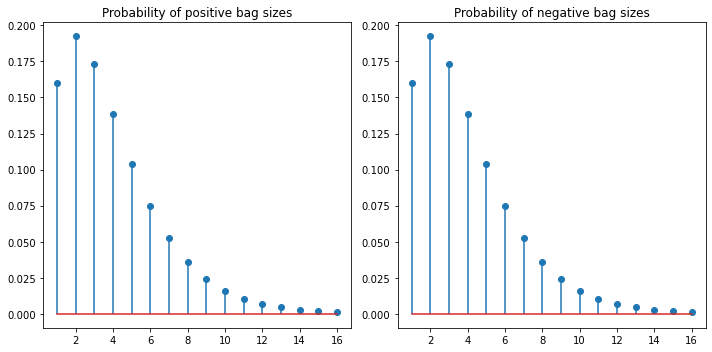

In [7]:
# Running a test to visualize the bagging simulator
bag_sim = Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0, censor_prob_neg=0)
X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
        bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi)

### C. Training the Model


[Return to top](#Notebook-contents)


Finally, we recreate the learning model and train it to the simulated dataset. Again, we first define some helper functions such as loss function, conversion of parameters (for reparameterization), initialization of weights and unpacking them, etc. Next, we train the model using stochastic gradient descent code from class. Finally, we combine everything together with the bagging simulator above, such that the function will take in an instance of a bagging simulator class, and run the necessary steps for the inputs to be bagged and used in training.

#### Analytical Gradient

Intstead of directly applying the gradient descent, we have also re-derive the analytical gradient for each of the parameter that we need to train for. Although we don't have time to implement these derivations in the main body of training process, we expect that with the aid of analytical expression the algorithm will get more efficient. The followings are gradient expression with respect to our parameters:

#### **Loss Function**

\begin{aligned}
L(\psi) &= -\sum_j Y_j \log (Q_j) + (1-Y_j) \log(1-Q_j)\\
\frac{d L}{d Q} &= -\sum_j \frac{Y_j}{Q_j} + \frac{1-Y_j}{1-Q_j}\\
\end{aligned}

As a reminder,

\begin{aligned}
Q_j &= 1 - \exp\left[-\mu R_j\right] \\
&= 1 - \exp\left[-\mu \sum_n f_\text{risk} (\bar{x_n}; \psi)\right]\\
f_\text{risk} &= \left[\sum_{b=1}^{N_B} \tau_{nb} w_b^{\text{ble}}\right] \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]
\end{aligned}


### **Gradient wrt to scale factor, $\mu$**

\begin{aligned}
\frac{d Q_j}{d \mu} &= R_j \exp\left[-\mu R_j\right]\\
&= \sum_n f_\text{risk} \exp\left[-\mu \sum_n f_\text{risk} (\bar{x_n}; \psi)\right]
\end{aligned}


### **Gradient wrt to bluetooth attenuation weights, $w_{1:4}^\text{ble}$**

Reminder of monotocity, where we are optimizing over $(w^{\text{ble}}_1, \Delta_2^{\text{ble}},\Delta_3^{\text{ble}},\Delta_4^{\text{ble}})$.


\begin{aligned}
\frac{d Q_j}{d w^{\text{ble}}_b} &= \frac{d Q_j}{df} \frac{df}{d w^{\text{ble}}_b}\\
&= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\tau_{nb} \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right)\\
\frac{d Q_j}{d w^{\text{ble}}_1}
&= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\left[\sum_{b=1}^{N_B} \tau_{nb} \right] \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right)\\
\frac{d Q_j}{d \Delta^{\text{ble}}_1} &= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\left[\sum_{b=2}^{N_B} \tau_{nb} \right] \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right)\\
\frac{d Q_j}{d \Delta^{\text{ble}}_2} &= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\left[\sum_{b=3}^{N_B} \tau_{nb} \right] \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right)\\
\frac{d Q_j}{d \Delta^{\text{ble}}_3} &= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\left[\sum_{b=4}^{N_B} \tau_{nb} \right] \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right)\\
\end{aligned}

### **Gradient wrt to bluetooth attenuation thresholds, $\theta_{1:3}^\text{ble}$**

Reminder of soft thresholding, where we are replacing hard binning with sigmoid function:

\begin{aligned}
\tau_{nb} &= \sum_k \tau_{nk} I \left(\theta^{\text{ble}}_{b-1} < a_{nk} \leq \theta^{\text{ble}}_{b}\right)\\
& \approx \sum_k \tau_{nk} \sigma_\tau (a_{nk} - \theta^{\text{ble}}_{b-1}) \sigma_\tau(\theta^{\text{ble}}_{b}-a_{nk})\\
& \approx \sum_k \tau_{nk} \left[\frac{1}{1+\exp(-t(a_{nk} - \theta^{\text{ble}}_{b-1}))}\right] \left[\frac{1}{1+\exp(-t(\theta^{\text{ble}}_{b}-a_{nk}))}\right]\\
\\
\end{aligned}

\begin{aligned}
\frac{d Q_j}{d \theta^{\text{ble}}_b} &= \frac{d Q_j}{df} \frac{df}{d\tau}\frac{d\tau}{d \theta^{\text{ble}}_b}\\
&= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\sum_{b=1}^{N_b} w_b^\text{ble} \; \times \; \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]\right) \frac{d\tau}{d \theta^{\text{ble}}_b}\\
\frac{d\tau}{d \theta^{\text{ble}}_b}
&= \sum_k \tau_{nk} \left[\frac{-t}{(1+\exp(-t(a_{nk} - \theta^{\text{ble}}_{b})))^2}\right] \left[\frac{1}{1+\exp(-t(\theta^{\text{ble}}_{b+1}-a_{nk}))}\right]\\
&+ \sum_k \tau_{nk} \left[\frac{1}{1+\exp(-t(a_{nk} - \theta^{\text{ble}}_{b-1}))}\right] \left[\frac{t}{(1+\exp(-t(\theta^{\text{ble}}_{b}-a_{nk})))^2}\right]
\end{aligned}

### **Gradient wrt to contagiousness weights, $w_{2:3}^\text{con}$**

Reminder of monotocity, where we are optimizing over $(w^{\text{con}}_2, \Delta^{\text{con}})$.


\begin{aligned}
\frac{d Q_j}{d w^{\text{ble}}_l} &= \frac{d Q_j}{df} \frac{df}{d w^{\text{con}}_l}\\
&= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\sum_{b=1}^{N_B} \tau_{nb} w_b^{\text{ble}} \; \times \; \sum_{l=1}^{N_C} I(c_{n,l})\right)\\
\frac{d Q_j}{d w^{\text{con}}_2}
&= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\sum_{b=1}^{N_B} \tau_{nb} w_b^{\text{ble}} \; \times \; \sum_{l=2}^{N_C} I(c_{n,l})\right)\\
\frac{d Q_j}{d \Delta^{\text{con}}} &= \left(\mu \exp\left[-\mu R_j\right]\right) \sum_n \left(\sum_{b=1}^{N_B} \tau_{nb} w_b^{\text{ble}} \; \times \; I(c_{n,3})\right)\\
\end{aligned}

#### Training Code

[Return to top](#Notebook-contents)

In [8]:
# basic configuration
n_rssi_buckets = 4
n_infect_levels = 3
rssi_lowest_th = -120
n_rssi_th = n_rssi_buckets-1  # number of thresholds for rssi buckets
model_dim = 1 + n_rssi_buckets + n_rssi_th + n_infect_levels  # total number of parameters

n_trials = 1
n_random_restarts_train = 5

# helper functions
def sigmoid_func(x):

    return 1/(1 + np.exp(-x))

# loss function
def cross_entropy_loss(y, q):
    return -np.mean(y*np.log(q) + (1-y)*np.log(1-q))

In [9]:
# initialize parameters
def get_init_parameters():
    beta = 0.1

    # rssi weights
    rssi_w_residual = np.random.rand(n_rssi_buckets) * 0.01

    # rssi thresholds
    rssi_th_residual = np.random.randint(low=10, high=40, size=n_rssi_th)

    # infectiousness weights
    infect_w_residual = np.random.rand(n_infect_levels) * 0.01

    return np.concatenate([[beta], rssi_w_residual, rssi_th_residual, infect_w_residual])


get_beta = lambda weights: weights[0]
get_rssi_w = lambda weights: weights[1:1+n_rssi_buckets]
get_rssi_th = lambda weights: weights[1+n_rssi_buckets:1+n_rssi_buckets+n_rssi_th]
get_infect_w = lambda weights: weights[1+n_rssi_buckets+n_rssi_th:1+n_rssi_buckets+n_rssi_th+n_infect_levels]

# helper function to unpack weights
def unpack_weights(weights):
    return get_beta(weights), get_rssi_w(weights), get_rssi_th(weights), get_infect_w(weights)


def residual_to_scoring(weights):
    # rssi weights
    rssi_w_residual = get_rssi_w(weights)
    rssi_w = [np.sum(rssi_w_residual[:i+1]) for i in range(n_rssi_buckets)]

    # rssi thresholds
    rssi_th_residual = get_rssi_th(weights)
    rssi_th =  [rssi_lowest_th+np.sum(rssi_th_residual[:i+1]) for i in range(n_rssi_th)]

    # infectiousness weights
    infect_w_residual = get_infect_w(weights)
    infect_w = [np.sum(infect_w_residual[:i+1]) for i in range(n_infect_levels)]

    return np.concatenate([[get_beta(weights)], rssi_w, rssi_th, infect_w])


def print_params(weights):
    print("    beta", get_beta(weights))
    print("    rssi_w", get_rssi_w(weights))
    print("    rssi_th", get_rssi_th(weights))
    print("    infect_w", get_infect_w(weights))

In [10]:
# continuous loss function, where attenuation is defined in terms of sigmoid functions
def loss_fn_ce(params, batch_x, batch_y, assign_mat, sigmoid_temp):

    f_rssi = batch_x[:, 0]
    beta, rssi_w, rssi_th, infect_w = unpack_weights(residual_to_scoring(params))
    infectiousness_bucket = np.eye(n_infect_levels)[np.array(batch_x[:, 2], dtype=int)]
    infectiousness_score = np.sum(np.multiply(np.array(infect_w), infectiousness_bucket), axis=1)

    rssi_score = rssi_w[0] * sigmoid_func(-sigmoid_temp * (f_rssi - rssi_th[0])) * \
                 sigmoid_func(10. * (f_rssi - rssi_lowest_th)) + rssi_w[-1] * \
                 sigmoid_func(sigmoid_temp * (f_rssi - rssi_th[n_rssi_buckets - 2]))
    rssi_score += np.dot(sigmoid_func(sigmoid_temp * (f_rssi[:, np.newaxis] - rssi_th[: n_rssi_buckets - 2])) \
                         * sigmoid_func(-sigmoid_temp * (f_rssi[:, np.newaxis] - rssi_th[1: n_rssi_buckets - 1])),
                         rssi_w[1: n_rssi_buckets - 1])
    rssi_score *= batch_x[:, 1]

    score = beta * rssi_score * infectiousness_score
    bag_scores = np.dot(assign_mat, score)
    bag_probs = 1 - np.exp(-bag_scores)
    bag_probs = np.clip(bag_probs, 1e-5, 1 - 1e-5)
    loss = cross_entropy_loss(batch_y, bag_probs)

    return loss, bag_probs

# discrete loss function, where attenuation is defined in terms of discrete bins
def loss_fn_stepbins_ce(params, batch_x, batch_y, assign_mat, return_scores=False):
    beta, rssi_w, rssi_th, infect_w = unpack_weights(residual_to_scoring(params))
    infectiousness_bucket = jax.nn.one_hot(batch_x[:, 2], num_classes=n_infect_levels)
    infectiousness_score = np.sum(np.multiply(np.array(infect_w), infectiousness_bucket), axis=1)
    rssi_bucket = np.eye(n_rssi_buckets)[np.array(np.digitize(batch_x[:, 0], rssi_th), dtype=int)]
    rssi_score = np.sum(np.multiply(np.array(rssi_w), rssi_bucket), axis=1) * batch_x[:, 1]

    score = beta * rssi_score * infectiousness_score
    if return_scores:
        return score
    bag_scores = np.dot(assign_mat, score)
    bag_probs = 1 - np.exp(-bag_scores)
    bag_probs = np.clip(bag_probs, 1e-5, 1 - 1e-5)
    loss = cross_entropy_loss(batch_y, bag_probs)

    return loss, bag_probs


# numerical calculation of the gradient of the loss function
def grad_loss_fn_ce(params, batch_x, batch_y, assign_mat, sigmoid_temp, batch_loss):
    def grad(idx):
        delta = 1e-10
        params_d = np.copy(params)
        params_d[idx] += delta
        return (loss_fn_ce(params_d, batch_x, batch_y, assign_mat, sigmoid_temp)[0] - batch_loss)/delta
    return np.asarray([grad(i) for i in range(len(params))])

In [11]:
def sigmoid_temp_fn(init, target, current_iter, num_iters):
    return np.interp(current_iter, [0, num_iters * 0.5, num_iters * 0.9, num_iters], [init, init, target, target])

# implementation of stochastic gradient descent
def train(features, bag_labels, assign_mat, sigmoid_temp_init, sigmoid_temp_target, batch_size, num_iters, lr):
    num_samples = len(bag_labels)
    batch_size = np.minimum(batch_size, num_samples)

    model_params = get_init_parameters()
    loss_start, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_init)
    loss_start_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("Start", "sigmoid loss", loss_start, "step loss", loss_start_step)

    for i in range(num_iters):
        l, r = i*batch_size%num_samples, (i+1)*batch_size%num_samples
        if l <= r:
            batch_y = bag_labels[l:r]
            batch_assign_mat = assign_mat[l:r]
        else:
            batch_y = np.concatenate([bag_labels[l:], bag_labels[:r]])
            batch_assign_mat = np.concatenate([assign_mat[l:], assign_mat[:r]], axis=0)

        sigmoid_temp = sigmoid_temp_fn(sigmoid_temp_init, sigmoid_temp_target, i, num_iters)

        loss, _ = loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp)
        grad = grad_loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp, loss)

        model_params -= lr * grad

        if i % 500 == 0:
            loss_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
            print("iter", i, "sigmoid loss", loss, "step loss", loss_step, "sigmoid temp", sigmoid_temp)

    loss_final, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_target)
    loss_final_step, probs_final = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("End", "sigmoid loss", loss_final, "step loss", loss_final_step)
    print_params(model_params)

    return model_params, loss_final_step, probs_final

# metric used for assessing method: AUC score
def auc(score_pred, labels):
    fpr, tpr, threshold = metrics.roc_curve(labels, score_pred)
    return metrics.auc(fpr, tpr)

In [12]:
# combining training, evaluation and bagging simulation
def train_and_eval_with_bag_config(bag_sim: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5, order=True):
    """Train the risk score model on data generated according to the given bag configuration. """
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        # Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi, visualize=False, order=order)
        best_loss = np.inf
        best_model_params = None
        best_final_probs = None
        for i in range(n_random_restarts):
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
            model_params, loss_st_step, final_probs = train(X, bag_labels_trn, assign_mat_trn,
                                               sigmoid_temp_init=0.1, sigmoid_temp_target=1,
                                               batch_size=200, num_iters=5000, lr=0.001)
            if loss_st_step < best_loss:
                best_loss = loss_st_step
                best_model_params = model_params
                best_final_probs = final_probs

        print("best loss", best_loss)
        print("best scoring parameters")
        print_params(residual_to_scoring(best_model_params))

        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
        auc_train_trials.append({
            'Learned': auc(best_final_probs, bag_labels_trn),
            'True': auc(probs_bags_true_trn, bag_labels_trn),
        })

        scores_learned = scores_learned = loss_fn_stepbins_ce(best_model_params, X, None, None, return_scores=True)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
        auc_test_trials.append({
            'Learned': auc(probs_learned_bags_tst, bag_labels_tst),
            'True': auc(probs_bags_true_tst, bag_labels_tst),
        })

    return auc_train_trials, auc_test_trials

## 4. Model and Experiments

[Return to top](#Notebook-contents)


⛔ PLEASE DO NOT RERUN THE EXPERIMENT PART SINCE IT TAKES EXTREMELY LONG TIME


A few experiments were performed around tweaking different features of the data to check that the parameter learning model is behaving as we expect it to. These experiments were geared towards an outcome-based focus (such that we want to see the outputs and use the expected trend of the output as a proxy for the "correctness" of the model), rather than a specific mechanics correctness check. The authors also compared the outcomes to the performance of a ground truth model ("True", in subsequent plots) and that of the Swiss model with fixed parameters. We decided to focus our efforts on comparing it to the ground truth to elucidate its general performance trends, since the Swiss model is not our focus.

An overview of the experiments and a brief summary of the results are listed below. Specific elaboration of each experiment follows in the respective subsections for the experiments.

1. **Maximum bag sizes were varied, while holding other parameters constant.** In particular, while the maximum bag size can go up to 32, the maximum number of positive exposures per bag remains fixed at 1.
2. **Censoring probability is varied, while holding other parameters constant.** Censoring probability refers to the chances of an exposure not being recorded and thus not being a part of the data. We test this with different censor probabilities, for fixed maximum bag sizes of 16 and 32, with a maximum of 1 positive exposure per bag.
3. **Varying positive bag construction, with varied maximum bag sizes.** The maximum number of positive exposures per bag can now go up to 3, while maximum bag sizes increases up to 32.
4. **Robustness to model mismatch.** Since we are working with simulated data, there is a probability that the simulated data is not reflective of the real world, and that data in the real world is much less precise. Hence, the original generative model is approximated and the resulting dataset tested on to see the performance of the current learning model to potentially different generative models.

In addition, we ran one of our own experiments just as corroboration to make sure that the learning model is not training or fitting specifically to a specific order of the data, again as a check for the robustness of the model in general.

5. **Reordering of data in training.** Training data is reordered so the model will learn parameters on different sequences of data points each time.

For all experiments, the metric used in the paper and which we are emulating is the AUC score. A higher AUC score reflects higher accuracy of the model in predicting the parameters that will generate a risk score which gives the maximum log-likelihood for the infection observation. Since we are using our own basic python code for the training, we do not have the efficiency gains of an ML package like `jax`. Hence, our code takes a very long while to run (about 20 minutes for 1 trial with 5 random starting points) and we were unable to run it multiple times to get replicates. Instead, we were only able to initialize the algorithm from 5 different starting points and plotted the results from the best output.

### 1. Varying maximum bag size

[Return to top](#Notebook-contents)

This experiment is iterated over increasing bag sizes to show the effect that increasing bag size has on the performance of the learning algorithm. Increasing bag size would increase uncertainty in assigning a risk score, since there is more noise with more observations, while the maximum number of positive exposures in the bag still remains fixed at 1. Hence, the signal of the one positive exposure (if it exists) gets drowned out as bag size increases, and it is harder to push the algorithm to an optimum which captures these signals well. 

We expect the performance of the algorithm to decrease, i.e. the AUC score to fall, as bag size increases. This is reflected in the two plots below, where the AUC drops from a high of around 0.9 to plateau arounnd 0.7. We also note that the performance of the learning algorithm is worse than that of the true parameters, which is to be expected. Overall, the trends for this experiment definitely supports the claim being made.

In [13]:
bag_size = [1, 2, 4, 8, 16, 32]
n_trials = 1
n_random_restarts_train = 5
idx = 0

auc_train_learned = np.zeros((len(bag_size),n_trials))
auc_train_true = np.zeros((len(bag_size),n_trials))
auc_test_learned = np.zeros((len(bag_size),n_trials))
auc_test_true = np.zeros((len(bag_size),n_trials))
for bs in bag_size:
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=bs,censor_prob_pos=0.,censor_prob_neg=0,max_pos_in_bag=1)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4431, 4431) (4431, 3)
assign_mat_trn size, assign_mat_tst size (3544, 4431) (887, 4431)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.2196481992672172 step loss 1.222210239360569
iter 0 sigmoid loss 0.9862754799858239 step loss 0.814513886000415 sigmoid temp 0.1
iter 500 sigmoid loss 0.34829134088286573 step loss 0.33055410146157227 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3654958522934435 step loss 0.3173655889164178 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3163487501708123 step loss 0.30776392023344307 sigmoid temp 0.1
iter 2000 sigmoid loss 0.34303746484624625 step loss 0.29532438249387144 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3010745930260712 step loss 0.30725786676460737 sigmoid temp 0.1
iter 3000 sigmoid loss 0.

iter 4500 sigmoid loss 0.37495171800940574 step loss 0.3490513812784508 sigmoid temp 1.0
End sigmoid loss 0.3371028905955947 step loss 0.3481930017405456
    beta 0.26619442821941275
    rssi_w [-0.00820623  0.01422462  0.21210928  0.13712829]
    rssi_th [18.01018765 36.01016367 32.99884028]
    infect_w [0.00944253 0.04811085 0.24852945]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.4386797658024109 step loss 1.437051178897278
iter 0 sigmoid loss 1.26710050584824 step loss 0.540926449889315 sigmoid temp 0.1
iter 500 sigmoid loss 0.33710987817393984 step loss 0.37760118046583463 sigmoid temp 0.1
iter 1000 sigmoid loss 0.4228594436300864 step loss 0.3630179279868117 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3776594556156215 step loss 0.3559227381650932 sigmoid temp 0.1
iter 2000 sigmoid loss 0.33448178270814977 step loss 0.38326814155192285 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3066721859569305 step loss 0.4287893896730894 sigmoid temp 0.1
iter 3000 

iter 4500 sigmoid loss 0.40110131135992083 step loss 0.3902550421131676 sigmoid temp 1.0
End sigmoid loss 0.38577807715733203 step loss 0.3907950402788242
    beta 0.3335286758414767
    rssi_w [-0.07584819 -0.06677438  0.19058492  0.23899636]
    rssi_th [11.0005262  35.00052862 31.99398383]
    infect_w [0.01031902 0.05503392 0.3159286 ]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 1.0484433033742078 step loss 1.0587712699886058
iter 0 sigmoid loss 0.8622807955403934 step loss 0.7670525044417578 sigmoid temp 0.1
iter 500 sigmoid loss 0.3629512560785062 step loss 0.38651290856272463 sigmoid temp 0.1
iter 1000 sigmoid loss 0.35881933266672017 step loss 0.3735329989261551 sigmoid temp 0.1
iter 1500 sigmoid loss 0.34054715434828803 step loss 0.36894619769280046 sigmoid temp 0.1
iter 2000 sigmoid loss 0.41951123149628833 step loss 0.541875603843097 sigmoid temp 0.1
iter 2500 sigmoid loss 0.32330832482106237 step loss 0.5689730730368658 sigmoid temp 0.1
iter 

iter 4500 sigmoid loss 0.4206628851940893 step loss 0.40039472266095844 sigmoid temp 1.0
End sigmoid loss 0.38871202477845457 step loss 0.4014085668291584
    beta 0.3192839032577609
    rssi_w [-0.05132325 -0.03842799  0.11761297  0.2893943 ]
    rssi_th [16.98970557 26.98970409 27.98812128]
    infect_w [0.00991987 0.03800155 0.30651046]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 1.2374652044087817 step loss 1.2697797102512385
iter 0 sigmoid loss 1.2976138857638984 step loss 0.5763021466150031 sigmoid temp 0.1
iter 500 sigmoid loss 0.4241994071074896 step loss 0.4116796711420008 sigmoid temp 0.1
iter 1000 sigmoid loss 0.4079279671152121 step loss 0.39619283423932644 sigmoid temp 0.1
iter 1500 sigmoid loss 0.39126940321822007 step loss 0.4218825181625615 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4249241941451551 step loss 0.7093116996353145 sigmoid temp 0.1
iter 2500 sigmoid loss 0.38229500069968725 step loss 0.7345878140197787 sigmoid temp 0.1
iter 30

iter 4500 sigmoid loss 0.43679432779395777 step loss 0.4158077196241885 sigmoid temp 1.0
End sigmoid loss 0.40470323843500783 step loss 0.4087460914588197
    beta 0.07536484219740058
    rssi_w [-0.02253801 -0.0067258   0.08045713  0.26329795]
    rssi_th [19.99400157 20.99403192 30.99339984]
    infect_w [0.10592904 0.08796898 0.3552571 ]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 1.1067272503033452 step loss 1.1115718601801887
iter 0 sigmoid loss 1.0502086881486052 step loss 0.6732712002007268 sigmoid temp 0.1
iter 500 sigmoid loss 0.4823979767143507 step loss 0.41582542594842986 sigmoid temp 0.1
iter 1000 sigmoid loss 0.42901097496177143 step loss 0.4067246366256657 sigmoid temp 0.1
iter 1500 sigmoid loss 0.36016451263982235 step loss 0.40384476046103407 sigmoid temp 0.1
iter 2000 sigmoid loss 0.41060781824615517 step loss 1.0947507774682055 sigmoid temp 0.1
iter 2500 sigmoid loss 0.34674874653780835 step loss 1.1815050986917504 sigmoid temp 0.1
ite

iter 4500 sigmoid loss 0.29961822864174914 step loss 0.37699547246921594 sigmoid temp 1.0
End sigmoid loss 0.3669119694932571 step loss 0.3768125801558805
    beta 0.2759777129572981
    rssi_w [-0.03090733 -0.02230944  0.0743536   0.26903605]
    rssi_th [16.00100298 23.00100458 26.00062674]
    infect_w [0.00573934 0.02682251 0.26771483]
best loss 0.3756677560178296
best scoring parameters
    beta 0.28135943247177264
    rssi_w [-0.07310736 -0.0759482   0.02305397  0.27850557]
    rssi_th [-81.99691797 -71.99393173 -54.99266255]
    infect_w [0.00582939 0.03338104 0.30491117]


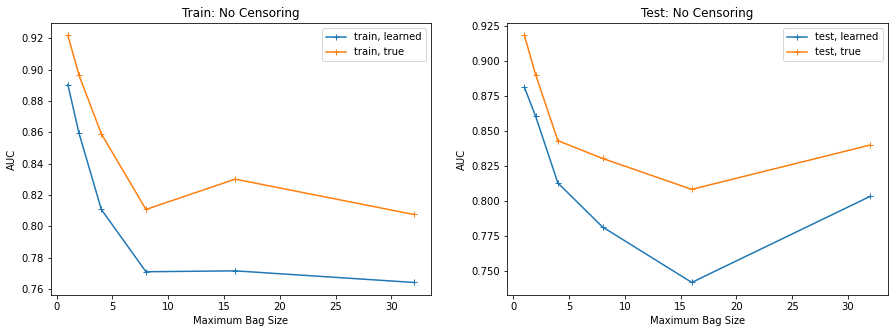

In [16]:
# the above two cells are deleted because of plotting redundancy

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(bag_size, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(bag_size, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Maximum Bag Size")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: No Censoring")
axs[0].legend()

axs[1].plot(bag_size, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(bag_size, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Maximum Bag Size")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: No Censoring")
axs[1].legend()

### 2. Varying censoring probability

[Return to top](#Notebook-contents)

This experiment is iterated over censoring probabilities to show the effect that increasing censoring probability has on the performance of the learning algorithm. Increasing censoring probability would reduce accuracy in assigning a risk score, since there is less signal when some positive exposures are censored or not taken into account in learning the model. With less data, the algorithm will definitely be biased against calculating a higher risk score. 

We expect the performance of the algorithm to decrease, i.e. the AUC score to fall, as censoring probability increases. This is reflected in the below too sets of experiments. When we set the maximum bag size to be 16, two plots shows that the AUC drops from a high of around 0.8 to less than 0.6. We even try a differnt maximum bag size (32) to cross check, and again the AUC drops from 0.8 - 0.55. Overall, the trends for this experiment supports the claim being made, although it definitely begs the question of what is the point of making this claim and experiment, knowing that this is a fundamental design flaw that may not be helpful to pandemic efforts (e.g. being more cautious and compensating for potentially censored exposures, instead of just recognizing and accepting that the prediction and risk scoring will drop). A discussion on this is expounded on in part III.1, Evaluation.

In [17]:
# max bag size 16
censor_prob = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
n_trials = 1
n_random_restarts_train = 5

idx = 0

auc_train_learned = np.zeros((len(censor_prob),n_trials))
auc_train_true = np.zeros((len(censor_prob),n_trials))
auc_test_learned = np.zeros((len(censor_prob),n_trials))
auc_test_true = np.zeros((len(censor_prob),n_trials))
for prob in censor_prob:
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=prob,censor_prob_neg=0,max_pos_in_bag=1)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 4.000, median size 3
	 Negative bags: mean size 3.971, median size 3
assign_mat size, X_shuff size: (4431, 17617) (17617, 3)
assign_mat_trn size, assign_mat_tst size (3532, 17617) (884, 17617)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 0.9485228239751493 step loss 0.9524340213955766
iter 0 sigmoid loss 1.0343423184328464 step loss 0.6536440470489701 sigmoid temp 0.1
iter 500 sigmoid loss 0.45214364711373617 step loss 0.42511188606857947 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3571010128038134 step loss 0.4195549973570463 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3435219386823791 step loss 0.41440946804973894 sigmoid temp 0.1
iter 2000 sigmoid loss 0.35325216987076385 step loss 0.5087466194759144 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3700036360287546 step loss 1.145408216296316 sigmoid temp 0.1
iter 3000 sigmoid loss

iter 4500 sigmoid loss 0.389049494861305 step loss 0.3980956753969632 sigmoid temp 1.0
End sigmoid loss 0.3900882935916594 step loss 0.39802476815877347
    beta 0.2919483028078872
    rssi_w [-0.01151736  0.04029357  0.26601983  0.08592018]
    rssi_th [31.99408322 35.99393058 18.99959966]
    infect_w [0.01145329 0.03194882 0.27620047]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.0670571800086088 step loss 1.0623264794717502
iter 0 sigmoid loss 1.4116791129770043 step loss 0.5488023859967738 sigmoid temp 0.1
iter 500 sigmoid loss 0.44038700731743147 step loss 0.43057351112953757 sigmoid temp 0.1
iter 1000 sigmoid loss 0.41605959155227734 step loss 0.4245035909108968 sigmoid temp 0.1
iter 1500 sigmoid loss 0.49748894954635325 step loss 0.42108460273633647 sigmoid temp 0.1
iter 2000 sigmoid loss 0.35562365338324325 step loss 0.4936779908743291 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4096309855039331 step loss 0.5187795456942368 sigmoid temp 0.1
iter 3

iter 4500 sigmoid loss 0.4287315544860122 step loss 0.46107723614891816 sigmoid temp 1.0
End sigmoid loss 0.43725261080247857 step loss 0.46020117120608584
    beta 0.2260951504322705
    rssi_w [-0.03317102  0.02232079  0.08911527  0.19004575]
    rssi_th [35.00058746 16.00051223 27.99716342]
    infect_w [0.02437053 0.02479763 0.20749323]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 0.9986099356031158 step loss 1.0105788815711287
iter 0 sigmoid loss 0.9534682455165338 step loss 0.676352305853482 sigmoid temp 0.1
iter 500 sigmoid loss 0.4549225267159791 step loss 0.4436914660345952 sigmoid temp 0.1
iter 1000 sigmoid loss 0.46102273543632394 step loss 0.4346812051356985 sigmoid temp 0.1
iter 1500 sigmoid loss 0.44278493282760034 step loss 0.4239584508694613 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4437346875873551 step loss 0.41826053726787266 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4351591404914782 step loss 0.42319932619469575 sigmoid temp 0.1
iter 3

iter 4500 sigmoid loss 0.5639393112901012 step loss 0.44000627145287435 sigmoid temp 1.0
End sigmoid loss 0.4292607761268049 step loss 0.4376260251472908
    beta 0.1718736048455071
    rssi_w [-0.00449395 -0.00559749  0.01534216  0.14319203]
    rssi_th [11.00451968 12.00453178 29.00453209]
    infect_w [0.02466868 0.02067534 0.14287634]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 0.9799640407576043 step loss 0.9697776644365664
iter 0 sigmoid loss 0.7876691247090409 step loss 0.6890607696721578 sigmoid temp 0.1
iter 500 sigmoid loss 0.4926341669459019 step loss 0.4396946857162193 sigmoid temp 0.1
iter 1000 sigmoid loss 0.41750314596419796 step loss 0.4372063355999314 sigmoid temp 0.1
iter 1500 sigmoid loss 0.4340642676788278 step loss 0.43657272471780023 sigmoid temp 0.1
iter 2000 sigmoid loss 0.34080081894701636 step loss 0.4361515295940306 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4383829580693521 step loss 0.43569686698537613 sigmoid temp 0.1
iter 30

iter 4500 sigmoid loss 0.46097907350054973 step loss 0.4290972989995316 sigmoid temp 1.0
End sigmoid loss 0.4252629625814993 step loss 0.42919212006514657
    beta 0.22124534320978598
    rssi_w [-0.03638763  0.00101764  0.07510408  0.18647587]
    rssi_th [33.00156364 15.00153722 16.00124738]
    infect_w [0.01790256 0.02809339 0.19991486]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 0.8911573584412767 step loss 0.894239624125361
iter 0 sigmoid loss 0.8312106161767413 step loss 0.689086468409968 sigmoid temp 0.1
iter 500 sigmoid loss 0.33089490178206377 step loss 0.45184317934002316 sigmoid temp 0.1
iter 1000 sigmoid loss 0.47667432835912565 step loss 0.4490469656299259 sigmoid temp 0.1
iter 1500 sigmoid loss 0.44214666790780127 step loss 0.44852108393065737 sigmoid temp 0.1
iter 2000 sigmoid loss 0.3986710137758685 step loss 0.4473048206825218 sigmoid temp 0.1
iter 2500 sigmoid loss 0.40317716055479047 step loss 0.4534008103795817 sigmoid temp 0.1
iter 

iter 4500 sigmoid loss 0.5183449980710413 step loss 0.44751794466521644 sigmoid temp 1.0
End sigmoid loss 0.444027607194745 step loss 0.447189863219822
    beta 0.1979141678847384
    rssi_w [0.00247538 0.00873832 0.03193863 0.17947988]
    rssi_th [10.00035868 20.00036399 34.00031369]
    infect_w [0.03017734 0.03241795 0.16946648]
best loss 0.447189863219822
best scoring parameters
    beta 0.1979141678847384
    rssi_w [0.00247538 0.0112137  0.04315233 0.22263222]
    rssi_th [-109.99964132  -89.99927734  -55.99896365]
    infect_w [0.03017734 0.06259529 0.23206177]
total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 3.854, median size 3
	 Negative bags: mean size 4.031, median size 3
assign_mat size, X_shuff size: (4431, 17737) (17737, 3)
assign_mat_trn size, assign_mat_tst size (3503, 17737) (876, 17737)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 0.9305103147358927 st

iter 1500 sigmoid loss 0.4627952730710912 step loss 0.45516953869446297 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4921212728842522 step loss 0.4549555499055795 sigmoid temp 0.1
iter 2500 sigmoid loss 0.38845123482287675 step loss 0.45526154352456377 sigmoid temp 0.1
iter 3000 sigmoid loss 0.47355223133692315 step loss 0.4552503392758387 sigmoid temp 0.325
iter 3500 sigmoid loss 0.46096018927304555 step loss 0.45500551152998175 sigmoid temp 0.55
iter 4000 sigmoid loss 0.4291620033327601 step loss 0.45491197087525537 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.4751036484476478 step loss 0.4548666263673317 sigmoid temp 1.0
End sigmoid loss 0.45348202575275753 step loss 0.4548140698241487
    beta 0.14728609837023612
    rssi_w [0.00731248 0.01810238 0.0530715  0.09736733]
    rssi_th [29.00160072 18.00160384 13.00162932]
    infect_w [0.05039158 0.00865997 0.10098917]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 0.9529191524880816 step loss 0.95

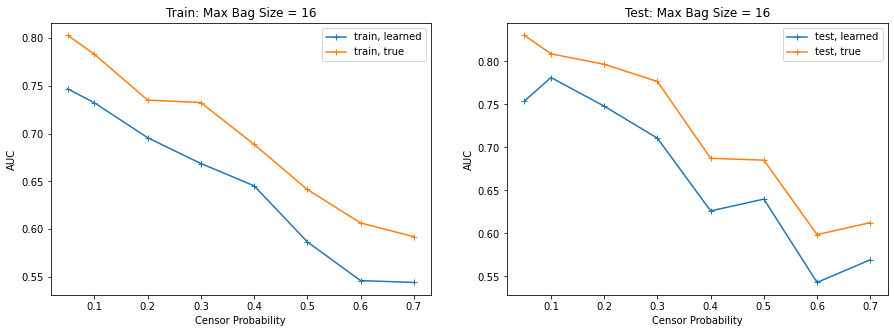

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(censor_prob, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(censor_prob, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Censor Probability")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: Max Bag Size = 16")
axs[0].legend()

axs[1].plot(censor_prob, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(censor_prob, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Censor Probability")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: Max Bag Size = 16")
axs[1].legend()

In [19]:
# max bag size 32
censor_prob = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
n_trials = 1
n_random_restarts_train = 5

idx = 0

auc_train_learned = np.zeros((len(censor_prob),n_trials))
auc_train_true = np.zeros((len(censor_prob),n_trials))
auc_test_learned = np.zeros((len(censor_prob),n_trials))
auc_test_true = np.zeros((len(censor_prob),n_trials))
for prob in censor_prob:
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=32,censor_prob_pos=prob,censor_prob_neg=0,max_pos_in_bag=1)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 4.287, median size 3
	 Negative bags: mean size 4.009, median size 3
assign_mat size, X_shuff size: (4431, 17962) (17962, 3)
assign_mat_trn size, assign_mat_tst size (3539, 17962) (886, 17962)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 0.9118934098450943 step loss 0.909669808186479
iter 0 sigmoid loss 0.6813132590804648 step loss 0.7224957709916452 sigmoid temp 0.1
iter 500 sigmoid loss 0.42864037965183344 step loss 0.4251824955255295 sigmoid temp 0.1
iter 1000 sigmoid loss 0.35591760806873546 step loss 0.4196330665695337 sigmoid temp 0.1
iter 1500 sigmoid loss 0.49162052755086877 step loss 0.41328101346893126 sigmoid temp 0.1
iter 2000 sigmoid loss 0.42485674607065205 step loss 0.4216879154718225 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3722794338677258 step loss 1.1317223003385162 sigmoid temp 0.1
iter 3000 sigmoid los

iter 4500 sigmoid loss 0.32586533889966113 step loss 0.412635354219877 sigmoid temp 1.0
End sigmoid loss 0.4089960427030807 step loss 0.41288195658665433
    beta 0.20245363613048398
    rssi_w [-0.02043003  0.03999343  0.16491407  0.08063926]
    rssi_th [33.0099112  24.00979046 34.99962448]
    infect_w [0.0074555  0.03742398 0.18014548]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.0509808439587844 step loss 1.0624912637332433
iter 0 sigmoid loss 1.0620104545632159 step loss 0.6919799742447202 sigmoid temp 0.1
iter 500 sigmoid loss 0.43708465341641306 step loss 0.44007726684970744 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3692436964218237 step loss 0.4366518657123465 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3540883287474905 step loss 0.4367854173780225 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4543005508205465 step loss 0.4433758145119965 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4503091204660633 step loss 0.4751853183848075 sigmoid temp 0.1
iter 300

iter 4500 sigmoid loss 0.3851130043216623 step loss 0.4314830869182055 sigmoid temp 1.0
End sigmoid loss 0.4278895794449158 step loss 0.4318875045904978
    beta 0.18231107462286503
    rssi_w [-0.00606771 -0.0056085   0.03354293  0.15533621]
    rssi_th [11.00629479 18.00630289 26.0062607 ]
    infect_w [0.01750993 0.02275888 0.15568493]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 0.9837152628256155 step loss 0.9753088325935021
iter 0 sigmoid loss 1.0021716967428251 step loss 0.6642001436522473 sigmoid temp 0.1
iter 500 sigmoid loss 0.43177755313560257 step loss 0.4473882058097413 sigmoid temp 0.1
iter 1000 sigmoid loss 0.4331932073040805 step loss 0.44552923350384005 sigmoid temp 0.1
iter 1500 sigmoid loss 0.4896612168219148 step loss 0.44569422495029043 sigmoid temp 0.1
iter 2000 sigmoid loss 0.46658607305153543 step loss 0.4528133367905907 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4103173869600594 step loss 0.4761702541524535 sigmoid temp 0.1
iter 30

iter 4500 sigmoid loss 0.486935627162822 step loss 0.439345110688053 sigmoid temp 1.0
End sigmoid loss 0.43537555230918973 step loss 0.4386412444494034
    beta 0.19275089807303517
    rssi_w [-0.00147577  0.02558054  0.08989928  0.14075895]
    rssi_th [30.00212776 23.00210033 26.99846332]
    infect_w [0.02181818 0.02998092 0.16539211]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 0.9842572198957232 step loss 0.9890190438358423
iter 0 sigmoid loss 1.070055167707073 step loss 0.6472942074830003 sigmoid temp 0.1
iter 500 sigmoid loss 0.4508460235926078 step loss 0.43820944593818517 sigmoid temp 0.1
iter 1000 sigmoid loss 0.42305099146228675 step loss 0.43185433959169994 sigmoid temp 0.1
iter 1500 sigmoid loss 0.4732355152131003 step loss 0.4249003193908451 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4290477037330709 step loss 0.4187520596593889 sigmoid temp 0.1
iter 2500 sigmoid loss 0.4584385605550256 step loss 0.41715914436361073 sigmoid temp 0.1
iter 3000

iter 4500 sigmoid loss 0.38515572203357806 step loss 0.4432191164640763 sigmoid temp 1.0
End sigmoid loss 0.4385595261527159 step loss 0.44384421094332654
    beta 0.23770571682947264
    rssi_w [-0.01477425  0.05253822  0.21173482  0.05693385]
    rssi_th [38.99611499 29.99583421 22.99974188]
    infect_w [0.03089407 0.02192226 0.2185698 ]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 1.1251017938771906 step loss 1.153248956285027
iter 0 sigmoid loss 1.1827454649428086 step loss 0.6365536877881028 sigmoid temp 0.1
iter 500 sigmoid loss 0.38767818118237946 step loss 0.4622200294211987 sigmoid temp 0.1
iter 1000 sigmoid loss 0.557755558522556 step loss 0.4582216430522008 sigmoid temp 0.1
iter 1500 sigmoid loss 0.4308674040525117 step loss 0.45874610951171907 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4552375072002184 step loss 0.46421757835856936 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3672370398162992 step loss 0.49110771892266186 sigmoid temp 0.1
iter 30

iter 4500 sigmoid loss 0.46795109173886457 step loss 0.467358459699436 sigmoid temp 1.0
End sigmoid loss 0.466141536086455 step loss 0.4673510778241987
    beta 0.18010156038462669
    rssi_w [-0.03095758 -0.01866058  0.11327139  0.1051141 ]
    rssi_th [26.00092401 21.00092798 34.99891061]
    infect_w [0.05830536 0.0340719  0.13844239]
best loss 0.4543422159568081
best scoring parameters
    beta 0.12391024600534309
    rssi_w [0.06007068 0.12340038 0.32767918 0.35781106]
    rssi_th [-92.00081338 -54.00172436 -26.00183636]
    infect_w [0.03059275 0.05480031 0.14788723]
total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 3.948, median size 3
	 Negative bags: mean size 4.049, median size 3
assign_mat size, X_shuff size: (4431, 17870) (17870, 3)
assign_mat_trn size, assign_mat_tst size (3492, 17870) (875, 17870)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.122070744003032

iter 1500 sigmoid loss 0.5085652774944142 step loss 0.45921051533791063 sigmoid temp 0.1
iter 2000 sigmoid loss 0.4977037633250163 step loss 0.4586980481405367 sigmoid temp 0.1
iter 2500 sigmoid loss 0.5250271974262489 step loss 0.45831163061109365 sigmoid temp 0.1
iter 3000 sigmoid loss 0.4345540268469537 step loss 0.45802535551316476 sigmoid temp 0.325
iter 3500 sigmoid loss 0.4217222315784516 step loss 0.4579799389705816 sigmoid temp 0.55
iter 4000 sigmoid loss 0.4932562526846435 step loss 0.45791290986815913 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.5054018519103042 step loss 0.4579194838652503 sigmoid temp 1.0
End sigmoid loss 0.45674383587181566 step loss 0.4579974604116454
    beta 0.15848293904708868
    rssi_w [-0.00099646  0.01315242  0.05480578  0.11448192]
    rssi_th [30.99882895 14.99883482 24.9985695 ]
    infect_w [0.06258591 0.02474049 0.10678335]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.1270915751440902 step loss 1.1

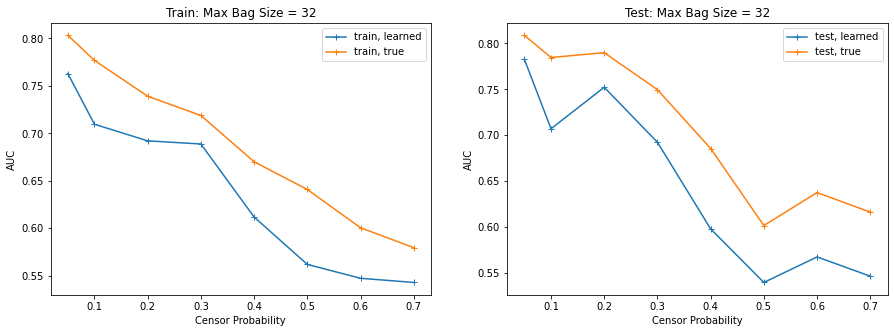

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(censor_prob, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(censor_prob, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Censor Probability")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: Max Bag Size = 32")
axs[0].legend()

axs[1].plot(censor_prob, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(censor_prob, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Censor Probability")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: Max Bag Size = 32")
axs[1].legend()

### 3. Varying Positive Bag Construction

[Return to top](#Notebook-contents)

This experiment first increases the maximum number of positive exposures per bag from 1 to 3, then iterates over increasing bag sizes. We want to compare the results here to that of Experiment 1., to show the effect that increasing maximum number of positive exposures has on the performance of the learning algorithm. Increasing maximum number of positive exposures would increase the signal received by the algorithm. Hence, the algorithm should perform better as long as the gain in signal (compared to experiment 1) is not outweighed by the gain in noise from increasing bag size. 

We expect the performance of the algorithm to increase, i.e. the AUC score to increase, compared to experiment 1. However, this will only happen for maximum bag sizes up till around 3 or 4, and will decrease after. This is reflected in the two plots below, where the AUC increases slightly (from around 0.8 to 0.9) up until a maximum bag size of 4, then drops. This trend supports the claim being made, since having up to 3 positive exposures in a bag is significant when the number of positive exposures make up a substantial percentage of the bag size. In this case, a maximum of 3 positive exposures in a bag of 4 exposures would mean a signal strength of 75%. However as the bag gets larger but the positive exposures remain at a fixed maximum of 3, it faces the same problem as Experiment 1 where the noise of the additional exposures drown out the signal. 

In [21]:
# effect of varying bag size, given up to 3 positive exposures per bag
bag_size = [1, 2, 4, 8, 16, 32]
n_trials = 1
n_random_restarts_train = 5

idx = 0

auc_train_learned = np.zeros((len(bag_size),n_trials))
auc_train_true = np.zeros((len(bag_size),n_trials))
auc_test_learned = np.zeros((len(bag_size),n_trials))
auc_test_true = np.zeros((len(bag_size),n_trials))
for bs in bag_size:
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=bs,censor_prob_pos=0.,censor_prob_neg=0,max_pos_in_bag=3)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4431, 4431) (4431, 3)
assign_mat_trn size, assign_mat_tst size (3544, 4431) (887, 4431)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.435833557100843 step loss 1.4919998719849097
iter 0 sigmoid loss 1.4457935865163787 step loss 0.6713896398738584 sigmoid temp 0.1
iter 500 sigmoid loss 0.39454125185947403 step loss 0.33957002420014953 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3095893621262033 step loss 0.33017755074426913 sigmoid temp 0.1
iter 1500 sigmoid loss 0.33892465124191545 step loss 0.3257831404756726 sigmoid temp 0.1
iter 2000 sigmoid loss 0.26839281863461933 step loss 0.3239480777134672 sigmoid temp 0.1
iter 2500 sigmoid loss 0.28425681386804286 step loss 0.32995353237192987 sigmoid temp 0.1
iter 3000 sigmoid loss 

iter 4500 sigmoid loss 0.2542830269043291 step loss 0.32905569172890275 sigmoid temp 1.0
End sigmoid loss 0.2941304094978999 step loss 0.3288035508403608
    beta 0.29751522417621457
    rssi_w [-0.05757349  0.04433764  0.15860202  0.22673117]
    rssi_th [37.00570723 15.00545638 27.99653896]
    infect_w [0.00603402 0.04106273 0.28536993]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.0601334787383894 step loss 1.0654949194468064
iter 0 sigmoid loss 0.8473871708757903 step loss 0.7719838610891679 sigmoid temp 0.1
iter 500 sigmoid loss 0.3358095408821296 step loss 0.31887620898804514 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3350853338556621 step loss 0.3064395364302617 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3291085029425044 step loss 0.2967381278475104 sigmoid temp 0.1
iter 2000 sigmoid loss 0.3530951516511754 step loss 0.2887718105380951 sigmoid temp 0.1
iter 2500 sigmoid loss 0.2933878997243796 step loss 0.7735290052018553 sigmoid temp 0.1
iter 3000

iter 4500 sigmoid loss 0.30168266503123276 step loss 0.3315158794176655 sigmoid temp 1.0
End sigmoid loss 0.30991339316690386 step loss 0.32304373093927113
    beta 0.24706479922743652
    rssi_w [-0.09225507 -0.03835916  0.20779519  0.19616545]
    rssi_th [29.00383935 20.00377375 35.99687701]
    infect_w [-0.02313488  0.09997147  0.32300484]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 1.0268411340218473 step loss 1.0266487973957241
iter 0 sigmoid loss 1.0223135992904222 step loss 0.6321602044295461 sigmoid temp 0.1
iter 500 sigmoid loss 0.31230767514244673 step loss 0.31419583184840894 sigmoid temp 0.1
iter 1000 sigmoid loss 0.2939397419853703 step loss 0.2976057751234797 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3186886246721539 step loss 0.2805673564093317 sigmoid temp 0.1
iter 2000 sigmoid loss 0.31279275482712465 step loss 0.472573501767167 sigmoid temp 0.1
iter 2500 sigmoid loss 0.24889500846355056 step loss 0.5279823734863572 sigmoid temp 0.1
it

<ipython-input-10-395ab36fc33b>:19: RuntimeWarning: overflow encountered in exp
  bag_probs = 1 - np.exp(-bag_scores)


iter 3000 sigmoid loss 0.361063284980753 step loss 0.3780265261237605 sigmoid temp 0.325
iter 3500 sigmoid loss 0.34023816510789084 step loss 0.34353019935326723 sigmoid temp 0.55
iter 4000 sigmoid loss 0.37793763709219325 step loss 0.32696753404057216 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.3295722714835959 step loss 0.31347956858420006 sigmoid temp 1.0
End sigmoid loss 0.29408189928379236 step loss 0.30341406381645697
    beta 0.1484755444118967
    rssi_w [-0.01813235  0.00640908  0.0569794   0.41795193]
    rssi_th [20.99382379 13.9938754  33.99351701]
    infect_w [-0.00643011  0.06611393  0.3235244 ]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 1.0169659204554367 step loss 1.0119708920559902
iter 0 sigmoid loss 0.9965926446947005 step loss 0.611458029663613 sigmoid temp 0.1
iter 500 sigmoid loss 0.3546095576688197 step loss 0.3367901473824934 sigmoid temp 0.1
iter 1000 sigmoid loss 0.326642512513709 step loss 0.3229570700660556 sigm

iter 3000 sigmoid loss 0.2968253711135796 step loss 0.4000035851690708 sigmoid temp 0.325
iter 3500 sigmoid loss 0.3745890384429692 step loss 0.3561649864528792 sigmoid temp 0.55
iter 4000 sigmoid loss 0.38725731952714026 step loss 0.36662921300409795 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.2500555710165875 step loss 0.36434578255789307 sigmoid temp 1.0
End sigmoid loss 0.3388179772676223 step loss 0.3623049301904934
    beta 0.14613440990341997
    rssi_w [-0.10771422 -0.00399769  0.23925365  0.21491513]
    rssi_th [35.00733858 15.00708283 36.99725229]
    infect_w [-0.02483374  0.06426976  0.3276071 ]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 1.020502828122302 step loss 1.0352542578316004
iter 0 sigmoid loss 0.8159785647510587 step loss 0.6886808369313763 sigmoid temp 0.1
iter 500 sigmoid loss 0.2664697308527969 step loss 0.3406726903657647 sigmoid temp 0.1
iter 1000 sigmoid loss 0.4181667215903628 step loss 0.5629326450987093 sigmo

iter 3000 sigmoid loss 0.3314354943827539 step loss 0.30033253227540013 sigmoid temp 0.325
iter 3500 sigmoid loss 0.3350205396755239 step loss 0.30194101077247143 sigmoid temp 0.55
iter 4000 sigmoid loss 0.23215721334821493 step loss 0.302532503440396 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.3069407341937681 step loss 0.3014733324683184 sigmoid temp 1.0
End sigmoid loss 0.2932807054399969 step loss 0.29980743486513833
    beta 0.2470613719689595
    rssi_w [-0.00613804  0.02256573  0.19495839  0.17723609]
    rssi_th [28.0084664  33.00839793 16.99841104]
    infect_w [-0.00620999  0.03736829  0.2656186 ]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 0.978260629044742 step loss 0.9807382829668692
iter 0 sigmoid loss 1.064646446431703 step loss 0.5715855998477232 sigmoid temp 0.1
iter 500 sigmoid loss 0.34838659944976974 step loss 0.35236041432211956 sigmoid temp 0.1
iter 1000 sigmoid loss 0.47517605188874584 step loss 0.3970444533548932 sigm

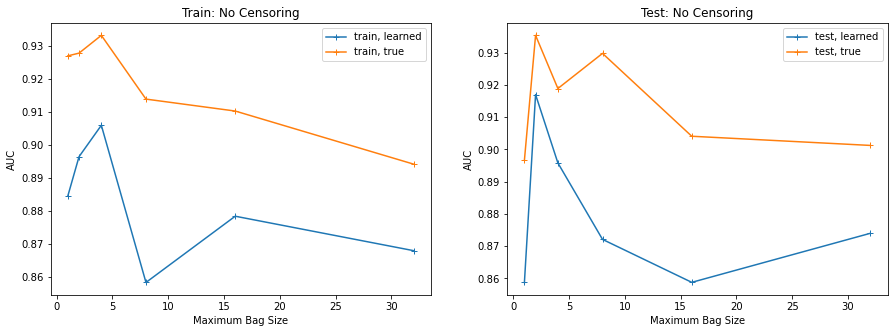

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(bag_size, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(bag_size, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Maximum Bag Size")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: No Censoring")
axs[0].legend()

axs[1].plot(bag_size, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(bag_size, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Maximum Bag Size")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: No Censoring")
axs[1].legend()

### 4. Robustness to Model Mismatch

[Return to top](#Notebook-contents)

Recognizing that the simulator may not be completely accurate or reflective of real data, slightly modifying the simulator by using a Taylor series approximation and then testing the performance of the model to see its robustness to slightly different generating models.

This experiment is iterated over decreasing number of Taylor approximation terms to show the effect that increasing model mismatch has on the performance of the learning algorithm. Decreasing the number of terms used in the Taylor approximation of the generative function that directly calculates the probability of infection would increase model mismatch in that the approximation becomes less accurate to the original function. Hence, the probability of infection calculated should be less accurate as well.

We expect the performance of the algorithm to decrease, i.e. the AUC score to fall, as model mismatch increases, or as the number of Taylor approximation terms decreases. 

This generic trend has been illustrated through the below two graphs. Reading from left to right following the x-axis (number of taylor terms increases), we do see a increase of AUC for the training set and testing sets. We can see they matche our expectation. However, for both sets the accuracy for using Inf terms (10 terms) is not clear that the infinity approximation seems to be less accurate than using less term. This phenomenon suggests two possibilities. First, our simulator may not be a very accruate model of how COVID is tranmitted, so that mismatch phenomenon is reflected not so completely. Second, our version of simulator is in general a robust one but with some noise. 

In [27]:
# initializing input data
distances, durations, symptoms = uniform_input_data_grid(max_dur = 60,  max_dist = 5, ngrid_dist = 80, ngrid_dur=20, min_dist=0.1, min_dur=5)
data = make_input_data(distances=distances, durations=durations, symptoms=symptoms)

# initializing parameters
ble_params = BleParams()
rssi = atten_to_rssi(data['atten_grid'], ble_params)
duration = data['duration_grid']
symptom_day = data['symptom_grid']
infectiousness = days_to_inf_levels(symptom_day)

params = ModelParams()

# Create model inputs
X = np.concatenate([rssi[:,None], duration[:,None], infectiousness[:,None]], axis=1)
approx_type = 'taylor'
exp_taylor_terms = 8
exp_temperature = np.arange(0.5,1.,0.09)

# calculating probability of infection
prob_infect_exact, prob_infect_approx = prob_infection_grid(data, params, approx=approx_type, exp_taylor_terms=exp_taylor_terms, temp=exp_temperature)
prob_infect_approx = np.array(prob_infect_approx)
# manually inspect the approximation error (higher error for larger values -- away from 0)
ind = np.where(prob_infect_exact>0.6)
print('Approx:', prob_infect_approx[:,ind])
print('Exact:', prob_infect_exact[ind])


print (X.shape, prob_infect_exact.shape)


simdata = dict()
simdata['X'] = X
simdata['prob_infect_exact'] = prob_infect_exact
simdata['prob_infect_approx'] = prob_infect_approx

X_epi = simdata['X']  
probabilities_true_epi = simdata['prob_infect_exact']
probabilities_true_epi_approx = simdata['prob_infect_approx'].T  # N x num_approx_steps
N = len(probabilities_true_epi)
perm = np.random.permutation(N)
X_epi = X_epi[perm, :]
probabilities_true_epi = probabilities_true_epi[perm]
probabilities_true_epi_approx = np.clip(probabilities_true_epi_approx[perm,:], 1e-5, 1-1e-5)
  
# generating labels for the exposure events
def sample_labels(probabilities):
  Y = bernoulli.rvs(probabilities)
  N_pos = np.sum(Y)
  N_neg = np.sum(1-Y)
  print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))
  pos_neg_ratio= float(N_neg) / N_pos
  return Y, N_pos, N_neg, pos_neg_ratio

Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)

Making grid of 80 distances x 20 durations x 21 onsets = 33600 points
Approx: [[[1.         1.         1.         ... 0.97538178 0.92937435 0.92675691]]

 [[0.49996063 0.49998181 0.46092688 ... 0.49969697 0.49750601 0.49731772]]

 [[0.67110338 0.66968263 0.81008083 ... 0.65435507 0.63129513 0.62997964]]

 ...

 [[0.63518322 0.63414931 0.72087815 ... 0.62280329 0.60509304 0.60406036]]

 [[0.63539429 0.63435626 0.72199235 ... 0.62296994 0.60521186 0.60417686]]

 [[0.63536768 0.63433023 0.72181414 ... 0.62294962 0.60519806 0.60416337]]]
Exact: [0.63537038 0.63433287 0.72183658 ... 0.62295162 0.60519936 0.60416464]
(33600, 3) (33600,)
total: 33600, positives: 5383, negatives: 28217


In [28]:
# parameters of training
n_trials = 1
n_random_restarts_train = 5

idx = 0

# taylor series approximation parameters
approx_type = 'taylor'
exp_taylor_terms = [np.inf, 8, 6, 4, 2]
exp_temperature = np.arange(0.5,1.,0.09)

auc_train_learned = np.zeros((len(exp_taylor_terms),n_trials))
auc_train_true = np.zeros((len(exp_taylor_terms),n_trials))
auc_test_learned = np.zeros((len(exp_taylor_terms),n_trials))
auc_test_true = np.zeros((len(exp_taylor_terms),n_trials))

for num_taylor_term in exp_taylor_terms:
  # generate probability of infection using taylor approximation
  prob_infect_exact, prob_infect_approx = prob_infection_grid(data, params, approx=approx_type, exp_taylor_terms=num_taylor_term, temp=exp_temperature)
  prob_infect_approx = np.array(prob_infect_approx)

  # store data
  simdata = dict()
  simdata['X'] = X
  simdata['prob_infect_exact'] = prob_infect_exact
  simdata['prob_infect_approx'] = prob_infect_approx

  # shuffle data points
  X_epi = simdata['X']  
  probabilities_true_epi = simdata['prob_infect_exact']
  probabilities_true_epi_approx = simdata['prob_infect_approx'].T  # N x num_approx_steps
  N = len(probabilities_true_epi)
  perm = np.random.permutation(N)
  X_epi = X_epi[perm, :]
  probabilities_true_epi = probabilities_true_epi[perm]
  probabilities_true_epi_approx = np.clip(probabilities_true_epi_approx[perm], 1e-5, 1-1e-5)
    
  # sample labels (exposure outcome) based on probability of infection
  Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)

  # initialize bag simulator and run the training
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=4,censor_prob_pos=0.,censor_prob_neg=0,max_pos_in_bag=3)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5403, negatives: 28197
total: 33600, positives: 5403, negatives: 28197
Empirical Bag sizes:
	 Positive bags: mean size 2.455, median size 2
	 Negative bags: mean size 2.431, median size 2
assign_mat size, X_shuff size: (4415, 10750) (10750, 3)
assign_mat_trn size, assign_mat_tst size (3532, 10750) (812, 10750)
Average positive samples per bag: 2.0126760563380284
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 0.9761889113483901 step loss 0.9897511676748867
iter 0 sigmoid loss 1.021417163339004 step loss 0.6673122182516648 sigmoid temp 0.1
iter 500 sigmoid loss 0.3314837361232751 step loss 0.31720750425336 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3065881446743266 step loss 0.3054449968220978 sigmoid temp 0.1
iter 1500 sigmoid loss 0.2324311130960724 step loss 0.3040847644574086 sigmoid temp 0.1
iter 2000 sigmoid loss 0.24234261433300083 step loss 0.4116515374821078 sigmoid temp 0.1
iter 2500 sigmoid loss 0.2565302668174569 step loss 

iter 4000 sigmoid loss 0.31200120179889007 step loss 0.3219838790594384 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.29435962872346266 step loss 0.3100061046808495 sigmoid temp 1.0
End sigmoid loss 0.2847850168481446 step loss 0.29039190893193384
    beta 0.08023396979851541
    rssi_w [-0.01629494 -0.00301911  0.02996466  0.28172842]
    rssi_th [15.01033151 15.01037937 28.01033439]
    infect_w [0.03016635 0.10810942 0.41291908]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 0.9413684972978628 step loss 0.9413802128677877
iter 0 sigmoid loss 0.7760000274832266 step loss 0.6944538456113053 sigmoid temp 0.1
iter 500 sigmoid loss 0.360834658239298 step loss 0.3192338694126401 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3185238389103641 step loss 0.30709457505287957 sigmoid temp 0.1
iter 1500 sigmoid loss 0.28578073056880654 step loss 0.2848294022250643 sigmoid temp 0.1
iter 2000 sigmoid loss 0.2795304098014802 step loss 0.44957906487704946 sigmoid 

iter 3500 sigmoid loss 0.26420561746554555 step loss 0.33854965358335554 sigmoid temp 0.55
iter 4000 sigmoid loss 0.3908630070758818 step loss 0.43167301741075464 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.3366091313470006 step loss 0.29782514793951603 sigmoid temp 1.0
End sigmoid loss 0.28899084562041794 step loss 0.29483027977583626
    beta 0.209520112423489
    rssi_w [-0.00697141  0.01390192  0.12561576  0.27034064]
    rssi_th [25.00654784 29.00651161 21.99549058]
    infect_w [0.00590323 0.03780186 0.3228653 ]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 1.0280442107310195 step loss 1.027821355378588
iter 0 sigmoid loss 1.086722516859532 step loss 0.6408307967415539 sigmoid temp 0.1
iter 500 sigmoid loss 0.40645069620904406 step loss 0.33775781913485664 sigmoid temp 0.1
iter 1000 sigmoid loss 0.30281622381367584 step loss 0.324872342092692 sigmoid temp 0.1
iter 1500 sigmoid loss 0.31669410942781384 step loss 0.3188704638686423 sigmoid

iter 3500 sigmoid loss 0.34072908004203994 step loss 0.32679764613498086 sigmoid temp 0.55
iter 4000 sigmoid loss 0.2780862334392855 step loss 0.33468625264282315 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.32055760016884877 step loss 0.32741954611150187 sigmoid temp 1.0
End sigmoid loss 0.32717552212168066 step loss 0.32705576593331515
    beta 0.012731011575406376
    rssi_w [0.78012639 0.79438412 0.87307363 0.39969228]
    rssi_th [17.99373204 26.99373631 15.99400732]
    infect_w [-0.01638142  0.05370691  0.16654075]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 1.042065751830827 step loss 1.0389162206987155
iter 0 sigmoid loss 1.0246137928883052 step loss 0.6211005420099378 sigmoid temp 0.1
iter 500 sigmoid loss 0.3124142733881703 step loss 0.316827986625363 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3494799453971373 step loss 0.3094626189193042 sigmoid temp 0.1
iter 1500 sigmoid loss 0.26952435941887537 step loss 0.29834074814418965 sigmo

iter 3000 sigmoid loss 0.33247612536952936 step loss 0.3030209125891851 sigmoid temp 0.325
iter 3500 sigmoid loss 0.23208702161638065 step loss 0.2821031192524758 sigmoid temp 0.55
iter 4000 sigmoid loss 0.2227167751714479 step loss 0.2757008941060939 sigmoid temp 0.7749999999999999
iter 4500 sigmoid loss 0.28283699565496795 step loss 0.2733812515856558 sigmoid temp 1.0
End sigmoid loss 0.25953788538864353 step loss 0.2753305669220631
    beta 0.29792164768217544
    rssi_w [-0.04110388 -0.02637844  0.08425594  0.32156406]
    rssi_th [21.00020233 21.00021167 21.99968127]
    infect_w [0.00377954 0.0294282  0.29818869]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 0.9575317925295885 step loss 0.9529882541240144
iter 0 sigmoid loss 0.7126572249482631 step loss 0.7202464905665807 sigmoid temp 0.1
iter 500 sigmoid loss 0.3273336272570387 step loss 0.34275693519703276 sigmoid temp 0.1
iter 1000 sigmoid loss 0.34734137935636483 step loss 0.34129994672236386 sig

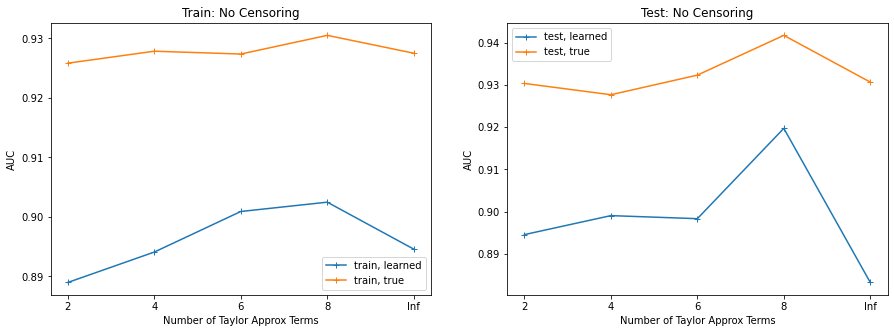

In [29]:
taylor_terms = [10, 8, 6, 4, 2]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(taylor_terms, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(taylor_terms, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Number of Taylor Approx Terms")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: No Censoring")
axs[0].set_xticks([10, 8, 6, 4, 2])
axs[0].set_xticklabels(['Inf', '8', '6', '4', '2'])
axs[0].legend()

axs[1].plot(taylor_terms, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(taylor_terms, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Number of Taylor Approx Terms")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: No Censoring")
axs[1].set_xticks([10, 8, 6, 4, 2])
axs[1].set_xticklabels(['Inf', '8', '6', '4', '2'])
#axs[1].set_xticks(['Inf', 8, 6, 4, 2])
axs[1].legend()

### 5. Reordering of data


[Return to top](#Notebook-contents)

Testing the robustness of the optimization routine to a reordering of the data points in the bagging simulation.

This experiment is iterated over increasing bag sizes, but the difference between this and experiment 1 is the shuffling of training data. We would expect the same trends as Experiment 1, and it acts more like a check to make sure that the learning model previously was not learning to a very specific sequence of the data and being biased. This is confirmed by two graphs below, where we can see the decreasing AUC following the increase of bag size. 


More discussion on this can be found in III.2 Future Work and Potential Modifications, under optimization of SGD.

In [30]:
# effect of reordering data points
bag_size = [1, 2, 4, 8, 16, 32]
n_trials = 1
n_random_restarts_train = 5


idx = 0

auc_train_learned = np.zeros((len(bag_size),n_trials))
auc_train_true = np.zeros((len(bag_size),n_trials))
auc_test_learned = np.zeros((len(bag_size),n_trials))
auc_test_true = np.zeros((len(bag_size),n_trials))
for bs in bag_size:
  bag_sim = Bag_Simulator(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=bs,censor_prob_pos=0.,censor_prob_neg=0,max_pos_in_bag=1)
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_sim, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train,order=False)
  for i in range(n_trials):
    auc_train_learned[idx, i] = dict(auc_train_trials[i])['Learned']
    auc_train_true[idx, i] = dict(auc_train_trials[i])['True']
    auc_test_learned[idx, i] = dict(auc_test_trials[i])['Learned']
    auc_test_true[idx, i] = dict(auc_test_trials[i])['True']
  
  idx += 1

total: 33600, positives: 5510, negatives: 28090
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4329, 4329) (4329, 3)
assign_mat_trn size, assign_mat_tst size (3463, 4329) (866, 4329)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.2200283407728685 step loss 1.2257949275655553
iter 0 sigmoid loss 7.437925088221127 step loss 0.3781165192511059 sigmoid temp 0.1
iter 500 sigmoid loss 0.13565879062049044 step loss 0.3403220812006198 sigmoid temp 0.1
iter 1000 sigmoid loss 0.12980633434680391 step loss 0.3493532206783222 sigmoid temp 0.1
iter 1500 sigmoid loss 0.11756154614373092 step loss 0.3355314300042378 sigmoid temp 0.1
iter 2000 sigmoid loss 0.15763043394481963 step loss 0.3303848238483888 sigmoid temp 0.1
iter 2500 sigmoid loss 0.15141073263349017 step loss 0.32850620685633036 sigmoid temp 0.1
iter 3000 sigmoid loss 0

iter 4500 sigmoid loss 0.09461132365252571 step loss 0.3387567309100637 sigmoid temp 1.0
End sigmoid loss 0.3218828624437763 step loss 0.33170778241367754
    beta 0.1771504102270448
    rssi_w [-0.00140747  0.02011427  0.20230656  0.25473526]
    rssi_th [22.00489773 34.00487007 17.99651483]
    infect_w [0.0100112  0.06349208 0.31908927]
----------- Trial 1/1: Training run 2/5 ----------------
Start sigmoid loss 1.102654276088049 step loss 1.104151060205447
iter 0 sigmoid loss 6.78115741327719 step loss 0.4170991766068726 sigmoid temp 0.1
iter 500 sigmoid loss 0.1231701906409905 step loss 0.3788378432461293 sigmoid temp 0.1
iter 1000 sigmoid loss 0.12997458136883897 step loss 0.36335639811675 sigmoid temp 0.1
iter 1500 sigmoid loss 0.14176886896335167 step loss 0.352392209629956 sigmoid temp 0.1
iter 2000 sigmoid loss 0.1484857388510517 step loss 0.3472376022782935 sigmoid temp 0.1
iter 2500 sigmoid loss 0.19322398247445466 step loss 0.35544639503900416 sigmoid temp 0.1
iter 3000 sig

iter 4500 sigmoid loss 0.11245254334407456 step loss 0.41772398717129133 sigmoid temp 1.0
End sigmoid loss 0.3798510567585645 step loss 0.4090799689780174
    beta 0.11477311661890469
    rssi_w [-0.02792297  0.00383463  0.23981065  0.13318216]
    rssi_th [22.0088452  30.00881967 35.99897639]
    infect_w [0.01247098 0.05057298 0.28247723]
----------- Trial 1/1: Training run 3/5 ----------------
Start sigmoid loss 1.1147611771318993 step loss 1.1297721113912131
iter 0 sigmoid loss 6.821063003990839 step loss 0.45636408640060205 sigmoid temp 0.1
iter 500 sigmoid loss 0.11076888560794645 step loss 0.40993654920150696 sigmoid temp 0.1
iter 1000 sigmoid loss 0.1368534662202971 step loss 0.39916566305188816 sigmoid temp 0.1
iter 1500 sigmoid loss 0.14638575816314914 step loss 0.39464656352550787 sigmoid temp 0.1
iter 2000 sigmoid loss 0.16855088635795043 step loss 0.39353721949737125 sigmoid temp 0.1
iter 2500 sigmoid loss 0.18441817881046998 step loss 0.40033207041983254 sigmoid temp 0.1


iter 4500 sigmoid loss 1.0000050000287821e-05 step loss 1.888354205673647 sigmoid temp 1.0
End sigmoid loss 1.888354205673647 step loss 1.888354205673647
    beta 3.854231831611978
    rssi_w [0.03898314 0.11924252 0.21172367 0.25933113]
    rssi_th [36.00123681 13.0011738  13.00137246]
    infect_w [-0.15446207 -0.04588106  0.19135725]
----------- Trial 1/1: Training run 4/5 ----------------
Start sigmoid loss 1.0156343766376088 step loss 1.0157415786427302
iter 0 sigmoid loss 6.21106125529065 step loss 0.4859054213430398 sigmoid temp 0.1
iter 500 sigmoid loss 0.113698877633251 step loss 0.43975992474233044 sigmoid temp 0.1
iter 1000 sigmoid loss 0.137735760093946 step loss 0.42276106841005795 sigmoid temp 0.1
iter 1500 sigmoid loss 0.14553928392405577 step loss 0.4096883462317898 sigmoid temp 0.1
iter 2000 sigmoid loss 0.1603300045055186 step loss 0.40284929561354255 sigmoid temp 0.1
iter 2500 sigmoid loss 0.23506008715940863 step loss 0.4058910479758703 sigmoid temp 0.1
iter 3000 si

iter 4500 sigmoid loss 0.10342300877529037 step loss 0.4035864628182036 sigmoid temp 1.0
End sigmoid loss 0.38171495944033906 step loss 0.3875661696787256
    beta 0.09934252134514701
    rssi_w [-0.01820138 -0.00172222  0.05710198  0.37194003]
    rssi_th [14.99997395 16.9999949  31.9997962 ]
    infect_w [0.0101385  0.05239699 0.28148766]
----------- Trial 1/1: Training run 5/5 ----------------
Start sigmoid loss 1.0818744158036557 step loss 1.0784272013508163
iter 0 sigmoid loss 6.637407803253684 step loss 0.5865157792280238 sigmoid temp 0.1
iter 500 sigmoid loss 0.10695061989092451 step loss 0.44546700607240614 sigmoid temp 0.1
iter 1000 sigmoid loss 0.12907723340553778 step loss 0.4318019642272524 sigmoid temp 0.1
iter 1500 sigmoid loss 0.13791713784064769 step loss 0.42561908890733907 sigmoid temp 0.1
iter 2000 sigmoid loss 0.16087578167368025 step loss 0.4337746281326564 sigmoid temp 0.1
iter 2500 sigmoid loss 0.20984413193998655 step loss 0.4526791759030183 sigmoid temp 0.1
ite

iter 4500 sigmoid loss 0.08977456255523972 step loss 0.41761568631159013 sigmoid temp 1.0
End sigmoid loss 0.39059263325953814 step loss 0.3994417856858591
    beta 0.10664200541788951
    rssi_w [-0.0385116  -0.01404745  0.10043055  0.39078713]
    rssi_th [22.99330113 17.99333782 26.99247926]
    infect_w [0.00805373 0.05262691 0.28860174]
best loss 0.39789662552064126
best scoring parameters
    beta 0.11011825553898227
    rssi_w [-0.08757291 -0.12305364  0.04854611  0.42088896]
    rssi_th [-88.00132862 -72.00266949 -52.00890592]
    infect_w [0.00802257 0.06120391 0.35615443]


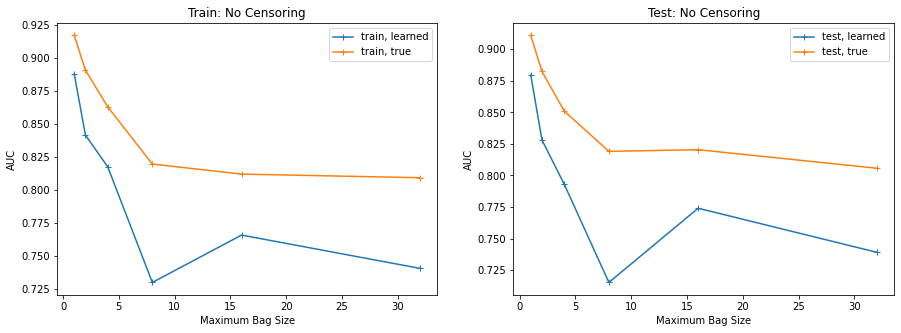

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(bag_size, np.mean(auc_train_learned, axis=1), '+-', label='train, learned')
axs[0].plot(bag_size, np.mean(auc_train_true, axis=1), '+-', label='train, true')
axs[0].set_xlabel("Maximum Bag Size")
axs[0].set_ylabel("AUC")
axs[0].set_title("Train: No Censoring")
axs[0].legend()

axs[1].plot(bag_size, np.mean(auc_test_learned, axis=1), '+-', label='test, learned')
axs[1].plot(bag_size, np.mean(auc_test_true, axis=1), '+-', label='test, true')
axs[1].set_xlabel("Maximum Bag Size")
axs[1].set_ylabel("AUC")
axs[1].set_title("Test: No Censoring")
axs[1].legend()

### 6. Examples of failure mode

[Return to top](#Notebook-contents)

Here we test out two scenarios of "failure". First is using a large learning rate in the traning process. The learning rate problem is briefly mentioned in II.2.2 when we introduce SGD alogirthm that SGD is sensitive to the learning rate. We show that if the learning rate is large (0.1 vs 0.001 original), the algorithm could not converge to a descent accuracy. Compared to original implementation, the accuracy is only 0.5 for training and 0.17 for testing, where the original hits 0.87 for both traning and testing, with truth being 0.9. The large learning rate is thus considered an example of failure becuase it results in tremedous drop in accuracy and it isnot better than randomlly guessing half of the population is infected. 


In [32]:
# failed experiment- learning rate edge 
def train_and_eval_with_bag_config_fail1(bag_sim: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5, order=True):
    """Train the risk score model on data generated according to the given bag configuration. """
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        # Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi, visualize=False, order=order)
        best_loss = np.inf
        best_model_params = None
        best_final_probs = None
        for i in range(n_random_restarts):
            # here we replace learning rate by 0.1
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
            model_params, loss_st_step, final_probs = train(X, bag_labels_trn, assign_mat_trn,
                                               sigmoid_temp_init=0.1, sigmoid_temp_target=1,
                                               batch_size=200, num_iters=5000, lr=0.1)
            if loss_st_step < best_loss:
                best_loss = loss_st_step
                best_model_params = model_params
                best_final_probs = final_probs

        print("best loss", best_loss)
        print("best scoring parameters")
        print_params(residual_to_scoring(best_model_params))

        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
        auc_train_trials.append({
            'Learned': auc(best_final_probs, bag_labels_trn),
            'True': auc(probs_bags_true_trn, bag_labels_trn),
        })

        scores_learned = scores_learned = loss_fn_stepbins_ce(best_model_params, X, None, None, return_scores=True)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
        auc_test_trials.append({
            'Learned': auc(probs_learned_bags_tst, bag_labels_tst),
            'True': auc(probs_bags_true_tst, bag_labels_tst),
        })

    return auc_train_trials, auc_test_trials

In [33]:
# original
n_trials = 1
n_random_restarts_train = 5
auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                n_trials=n_trials, n_random_restarts=n_random_restarts_train)

total: 33600, positives: 5510, negatives: 28090
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4329, 4329) (4329, 3)
assign_mat_trn size, assign_mat_tst size (3463, 4329) (866, 4329)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.1219768761036102 step loss 1.1134305430934133
iter 0 sigmoid loss 0.9663027166935403 step loss 0.837428210184174 sigmoid temp 0.1
iter 500 sigmoid loss 0.36271120524836975 step loss 0.3381407657863293 sigmoid temp 0.1
iter 1000 sigmoid loss 0.36149079470830925 step loss 0.3275225543097697 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3758836523867663 step loss 0.31989607206949394 sigmoid temp 0.1
iter 2000 sigmoid loss 0.3699628598627152 step loss 0.3107080338066055 sigmoid temp 0.1
iter 2500 sigmoid loss 0.30020568475549064 step loss 0.4402199868299871 sigmoid temp 0.1
iter 3000 sigmoid loss 0.3

In [34]:
## Failure due to large learning rate 
# lr = 0.1
auc_train_trials_fail1, auc_test_trials_fail1 = train_and_eval_with_bag_config_fail1(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                                  censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                    n_trials=n_trials, n_random_restarts=n_random_restarts_train)

total: 33600, positives: 5510, negatives: 28090
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4329, 4329) (4329, 3)
assign_mat_trn size, assign_mat_tst size (3463, 4329) (866, 4329)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.1040380849114508 step loss 1.1100025411852166
iter 0 sigmoid loss 0.7472514014654863 step loss 6.940842522733289 sigmoid temp 0.1
iter 500 sigmoid loss 1.5542535878142312 step loss 1.8883542056736473 sigmoid temp 0.1
iter 1000 sigmoid loss 2.0147702064110398 step loss 1.8883542056736473 sigmoid temp 0.1
iter 1500 sigmoid loss 1.7269473197880345 step loss 1.8883542056736473 sigmoid temp 0.1
iter 2000 sigmoid loss 1.8420764744372367 step loss 1.8883542056736473 sigmoid temp 0.1
iter 2500 sigmoid loss 2.3025930930340457 step loss 1.8883542056736473 sigmoid temp 0.1
iter 3000 sigmoid loss 2.18746

In [35]:
print(auc_train_trials, auc_test_trials)
print(auc_train_trials_fail1, auc_test_trials_fail1)

[{'Learned': 0.8815031379989784, 'True': 0.9200731591622273}] [{'Learned': 0.8578709828028948, 'True': 0.898470936113921}]
[{'Learned': 0.5, 'True': 0.9113959230338856}] [{'Learned': 0.17880417866313908, 'True': 0.9314790677768267}]


The second senario we want to test is using a very large bag size (128), compared to the largest bag size of 32 that we used in our main experiment. To save time, we do not incorporate random restart in this part but we compare the large bag size implementation with the original one. Notice that the train accuracy has dropoed to 0.5, and test accuracy has dropped to 0.34 The scenario is considered another example of failure because it is not better than randomlly guessing half of the population is infected or not.

In [36]:
# failed experiment- very large bag size

# original with only one restarts
auc_train_trials2, auc_test_trials2 = train_and_eval_with_bag_config(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                n_trials=n_trials, n_random_restarts=1)

total: 33600, positives: 5510, negatives: 28090
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4329, 4329) (4329, 3)
assign_mat_trn size, assign_mat_tst size (3463, 4329) (866, 4329)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/1 ----------------
Start sigmoid loss 1.2482413242950465 step loss 1.257868839025658
iter 0 sigmoid loss 1.3089002228609719 step loss 0.8105117319211484 sigmoid temp 0.1
iter 500 sigmoid loss 0.3601045326008543 step loss 0.3504521219930372 sigmoid temp 0.1
iter 1000 sigmoid loss 0.32678743194839205 step loss 0.3402750577323596 sigmoid temp 0.1
iter 1500 sigmoid loss 0.2814995703769667 step loss 0.33519728759973993 sigmoid temp 0.1
iter 2000 sigmoid loss 0.28184545917561143 step loss 0.3321994978236391 sigmoid temp 0.1
iter 2500 sigmoid loss 0.28785784219343813 step loss 0.3420697972974473 sigmoid temp 0.1
iter 3000 sigmoid loss 0.3

In [37]:
# failure due to large bag size
# bag size = 128
auc_train_trials_fail2, auc_test_trials_fail2 = train_and_eval_with_bag_config(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=128,
                                                                                                  censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                    n_trials=n_trials, n_random_restarts=1)


total: 33600, positives: 5510, negatives: 28090
Empirical Bag sizes:
	 Positive bags: mean size 5.424, median size 5
	 Negative bags: mean size 5.676, median size 5
assign_mat size, X_shuff size: (4329, 24393) (24393, 3)
assign_mat_trn size, assign_mat_tst size (3463, 24393) (853, 24393)
Average positive samples per bag: 2.0225352112676056
----------- Trial 1/1: Training run 1/1 ----------------
Start sigmoid loss 1.1043613021850538 step loss 1.106081606826197
iter 0 sigmoid loss 0.9274505669663057 step loss 0.5786967530300093 sigmoid temp 0.1
iter 500 sigmoid loss 0.40193995281904654 step loss 0.36923183783669455 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3345641027245263 step loss 0.35555054529122104 sigmoid temp 0.1
iter 1500 sigmoid loss 0.3523339335787491 step loss 0.65126397413235 sigmoid temp 0.1
iter 2000 sigmoid loss 2.01477020641104 step loss 1.888354205673647 sigmoid temp 0.1
iter 2500 sigmoid loss 1.49668901048963 step loss 1.888354205673647 sigmoid temp 0.1
iter 3000 sigmoi

In [38]:
print(auc_train_trials2, auc_test_trials2)
print(auc_train_trials_fail2, auc_test_trials_fail2)

[{'Learned': 0.8425077233695785, 'True': 0.9157514169646549}] [{'Learned': 0.8392002567893548, 'True': 0.916810948564314}]
[{'Learned': 0.5, 'True': 0.8811789997324186}] [{'Learned': 0.3443671876547612, 'True': 0.8843277668825895}]


# III. Discussion

## 1. Evaluation

Overall, this seems like a pretty generic workflow similar to what we are used to in class–define a generative model, get data, use data to predict optimal parameter values for the model and check the accuracy with a predefined loss function. We do not see any major standout issues. However, we do see room to question some of their design choices.

### 1.1 Choice of Loss Function
For example, we find that the author's choice of loss function does not reflect real world considerations fully. In the context of the pandemic, we would prefer a model that is more liberal in its estimates of risk because we would ideally want to err on the side of caution in the short run—we would rather isolate individuals who may not be infected, than to let individuals who are infected roam freely. In this sense, we would prefer a model with a higher false positive rate than a lower false negative rate. The loss function that is being minimized over right now does not seem to take this into account by weighing equally the risk scores for those infected and those not infected. From a practical, policy standpoint, we might want to adjust this to be more liberal in predictions. Alternatively, recognizing this feature of the model can also lead to a practical implementation where the threshold for alerting users of their close contact status is lower to compensate for the predictions.

### 1.2 Robustness to Model Mismatch
This discussion continues from Experiment 4 in the previous section. In the paper, the authors tested the robustness of their model to a potential model mismatch, by using a Taylor series approximation to the generative function for calculating the probability of infection. Poorer approximations (with fewer terms) would therefore mean a greater mismatch. However, this still assumes that the underlying model is fixed and is correct, while the approximations just appear to mimic noise in the real world. We find that the authors have not sufficiently proven that the model is truly robust to model mismatches where the generative model they have assumed is almost fundamentally flawed in design to begin with. This may potentially disadvantage their model in favor of an expert-driven model, since it is less flexible to change the whole structure of the learning model and re-learn parameters, compared to an expert changing guidance on thresholds immediately in response to the pandemic.

### 1.3 Comparison with Expert Guided Fixed Thresholds
Another consideration we had was the author's claim that their model performs better than fixed models with expert-guided thresholds. While they did perform a comparison with the Swiss model, we are hard pressed to accept this comparison as sufficient evidence that their claim holds. For one, the data they used to test both models originated from their data generator with specific parameters. They have not provided us with enough evidence to show that the data generated is reflective of the real world (apart from the fact that the equations are based on real world physics, there is no explicit justification for the parameters used in generating data) and less that it is reflective of the situation in Switzerland, which the Swiss model was presumably being tested in. Second, since we (and the authors) did not have access to the data from the GAEN app, we can only take the author's word that the data generated from their simulation was similar enough to that collected by GAEN, that the model can be easily ported over for integration and use with GAEN.

### 1.4 Accuracy and Uncertainty of Model
Nonetheless, it seems promising that we are seeing the right trends in the other experiments they conducted to test their own algorithm. For example, increasing bag size and censoring probability increases the difficulty of the optimization since there is potentially more noise or less signal, and we see a corresponding decrease in accuracy. Increasing signal through increasing positive bag constructions increases accuracy to a certain point where the benefit of the increased signal is trumped by the drawbacks of noise. These experiments give us confidence that the model is being uncertain in the right conditions as we expect. 

However, further work would need to be done to properly quantify the level of uncertainty and decide if it is practical. For example, we see that the inaccuracy drops as bag size increases, but the main experiments only tested until a bag size of 32. It is unclear if this is a realistic bag size to work with for real data, especially at the height of the pandemic when a single person may have many exposure events that it presents a separate problem just deciding which exposure events go in one bag and how to aggregate risk scores across different bags meaningfully. Moreover, if an ideal bag size is larger than 32, like in the demonstration of failure mode No.2, then we know for a fact that the accuracy will drop which begs the question of whether any potential gains in accuracy over an expert determined model is significant enough to justify an ML model. If anything, the experiments definitely highlighted that a lot of the parameters (e.g. maximum bag size, maximum number of positive exposures, censoring probability) can and probably should be tuned according to what we know of the real world constraints. For example, we would want to adjust the maximum bag size to make sure that there is substantive signal from positive exposures, given the average number of positive exposures a person may receive daily, but also make sure the bag size is still realistic and efficient to run. Censoring probability in real life would also come with knowledge of take-up rates of the contact tracing app and how well people use them. Depending on that, we would have a gauge of where the model could fail and compensate or guard against it.

Last but no the least, through the failure mode No.1, we acknowledge that every algorithm has its advantages and drawbacks and some uncareful choice of parameters can result in decreasing model accuracy (increasing model uncertainty). For example, the SGD algorithm is sensitive to the learning rate, if the rate is set to be extremely low or high, the gradient search will stuck in a place or jump frantically. Other ML algorithms have issues, too, such as too easy to overfit. To conclude, the story warns us that we have to be aware of the inherited problems associated with specific alogorithm to choose in the problem. Some algorithm needs to be carefully tuned before experiments. As an extension, we actually optimize the algorithm in III.2 Future Work and Potential Modifications. 


## 2. Future Work and Potential Modifications

### 2.1 Possible Modification 1: Optimization for SGD

Based on the common tricks mentioned in LeCun et al.'s Backprop chapter [11], we could consider the following methods for improving the performance of the stochastic gradient descent.

1. **Shuffling and Curriculum Learning.** Generally, we want to avoid providing the training examples in a meaningful, consistent order to our model as this may bias the optimization algorithm. Consequently, it is often a good idea to shuffle the training data after every epoch.

2. **Batch Normalization.** To facilitate learning, we typically normalize the initial values of our parameters by initializing them with zero mean and unit variance. As training progresses and we update parameters to different extents, we lose this normalization, which slows down training and amplifies changes as the network becomes deeper.

  According to Ioffe and Szegedy's paper on Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [12], batch normalization reestablishes these normalizations for every mini-batch and changes are back-propagated through the operation as well. By making normalization part of the model architecture, we are able to use higher learning rates and pay less attention to the initialization parameters. Batch normalization additionally acts as a regularizer, reducing (and sometimes even eliminating) the need for Dropout.

3. **Early Stopping.** According to Geoff Hinton: "Early stopping is beautiful free lunch" (NIPS 2015 Tutorial slides, slide 63). We should thus always monitor error on a validation set during training and stop (with some patience) if our validation error does not improve enough.

We also recognize that even though these tricks have their advantages, we cannot blindly assume that their benefits hold true for all machine learning models. There is definitely room to understand our model better and see if there is even a need to be concerned about certain things, like batch normalizations, if the model was actually simple enough that the learning and update of parameters need not be complicated further.

### 2.2 Possible Modification 2: Other Parameter Learning Methods

Here, we explore specific learning methods that can enhance SGD for more efficient learning.

1. **Momentum.** SGD has trouble navigating ravines, i.e. areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the ravine while only making hesitant progress along the bottom towards the local optimum. Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It does this by adding a fraction $\gamma$ of the update vector of the past time step to the current update vector: 
\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}

  This could potentially help speed up the efficiency of the SGD algorithm, though careful tuning would be needed to avoid too big a momentum such that the SGD falls into a local optimum too quickly and the algorithm terminates prematurely.

2. **Adagrad.** Adagrad is an algorithm for gradient-based optimization. It adapts the learning rate to the parameters, performing smaller updates (i.e. low learning rates) for parameters associated with frequently occurring features, and larger updates (i.e. high learning rates) for parameters associated with infrequent features. For this reason, it is well-suited to dealing with sparse data. Dean et al. found in their paper, Large Scale Distributed Deep Networks [13], that Adagrad greatly improved the robustness of SGD and used it for training large-scale neural nets at Google, which—among other things—learned to recognize cats in YouTube videos.

  In its update rule, Adagrad modifies the general learning rate $\eta$ at each time step $t$ for every parameter $\theta_i$ based on the past gradients that have been computed for $\theta_i$:
$$\theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t, ii} + \epsilon}} \cdot g_{t, i}$$
\
$G_{t, ii}$ here is a diagonal matrix where each diagonal element $i$, $i$ is the sum of the squares of the gradients w.r.t. $\theta_i$ up to time step $t$, while $\epsilon$ is a smoothing term that avoids division by zero (usually on the order of 1e−8).

  While this method may have its benefits, for our particular model, it may not be completely relevant since we are not exactly working with sparse data (and also assume that our data is complete, save for the censoring). Nonetheless, in a real world setting, as the authors of our paper have mentioned, it is likely that the contact tracing app may miss picking up on a lot of exposure events. Hence, the problem may be reformulated to be one of determining risk score with sparse data, and this method may come in handy then.

3. **Adadelta.** Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size $w$. With Adadelta, we do not even need to set a default learning rate, as it has been eliminated from the update rule.

4. **Adam.** Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $v_t$ like Adadelta, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum. Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface. We compute the decaying averages of past and past squared gradients $m_t$ and $v_t$ respectively as follows:

$$
\begin{align} 
\begin{split} 
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
\end{split} 
\end{align}
$$

Ultimately, it is a balance we need to strike between overcomplicating the model and optimizing methods for greater efficiency.


### 2.3 Implementation of Optimization

In this part, we implement several proposed optimization methods. 

In [ ]:
# Implementation of Optimization 1 - Shuffling and Curriculum Learning.

def train_and_eval_with_bag_config_mod_v1(bag_sim: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5):
    '''
    first modification - Shuffling and Curriculum Learning.
    '''
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        # Since there is alrealy randomness inside the bag_sim.simulate_bagged_data function, we
        # don't implement shuffling here for each trial
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
            bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi, visualize=False)
        best_loss = np.inf
        best_model_params = None
        best_final_probs = None
        for i in range(n_random_restarts):
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
            # Modification here, shuffling here before each iteration
            # Since our three input variables for training input are dependent of each other
            # need to wisely shuffle the data
            idx1 = np.arange(assign_mat_trn.shape[0])
            np.random.shuffle(idx1)
            bag_labels_trn = bag_labels_trn[idx1]
            assign_mat_trn = assign_mat_trn[idx1, :]

            model_params, loss_st_step, final_probs = train(X, bag_labels_trn, assign_mat_trn,
                                               sigmoid_temp_init=0.1, sigmoid_temp_target=1,
                                               batch_size=200, num_iters=5000, lr=0.001)
            if loss_st_step < best_loss:
                best_loss = loss_st_step
                best_model_params = model_params
                best_final_probs = final_probs

        print("best loss", best_loss)
        print("best scoring parameters")
        print_params(residual_to_scoring(best_model_params))

        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
        auc_train_trials.append({
            'Learned': auc(best_final_probs, bag_labels_trn),
            'True': auc(probs_bags_true_trn, bag_labels_trn),
        })

        scores_learned = loss_fn_stepbins_ce(best_model_params, X, None, None, return_scores=True)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
        auc_test_trials.append({
            'Learned': auc(probs_learned_bags_tst, bag_labels_tst),
            'True': auc(probs_bags_true_tst, bag_labels_tst),
        })

    return auc_train_trials, auc_test_trials

In [ ]:
## Original Implementation for Comparison
auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                n_trials=n_trials, n_random_restarts=n_random_restarts_train)

total: 33600, positives: 5468, negatives: 28132
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4362, 4362) (4362, 3)
assign_mat_trn size, assign_mat_tst size (3489, 4362) (873, 4362)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.175454359499679 step loss 1.1832132363026815
iter 0 sigmoid loss 1.117649362414514 step loss 0.8203591934372848 sigmoid temp 0.1
iter 500 sigmoid loss 0.35707710172401136 step loss 0.35665064280738146 sigmoid temp 0.1
iter 1000 sigmoid loss 0.30134682717362193 step loss 0.3477959750554159 sigmoid temp 0.1
iter 1500 sigmoid loss 0.320967402585495 step loss 0.341930252024401 sigmoid temp 0.1
iter 2000 sigmoid loss 0.3601606781223854 step loss 0.33620355160992454 sigmoid temp 0.1
iter 2500 sigmoid loss 0.3108253803566541 step loss 0.33951994942820707 sigmoid temp 0.1
iter 3000 sigmoid loss 0.283

In [ ]:
## Implementation for Optimization
auc_train_trials_mod1, auc_test_trials_mod1 = train_and_eval_with_bag_config_mod_v1(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                                  censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                    n_trials=n_trials, n_random_restarts=n_random_restarts_train)

total: 33600, positives: 5468, negatives: 28132
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4362, 4362) (4362, 3)
assign_mat_trn size, assign_mat_tst size (3489, 4362) (873, 4362)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.1401424218642982 step loss 1.1436560013052968
iter 0 sigmoid loss 1.3462001999257598 step loss 0.7672636596642491 sigmoid temp 0.1
iter 500 sigmoid loss 0.3431212433022248 step loss 0.36417474510526776 sigmoid temp 0.1
iter 1000 sigmoid loss 0.33504211084725966 step loss 0.36078466496277367 sigmoid temp 0.1
iter 1500 sigmoid loss 0.34733871864549487 step loss 0.36087523781564873 sigmoid temp 0.1
iter 2000 sigmoid loss 0.31419139476353386 step loss 0.3608011422532609 sigmoid temp 0.1
iter 2500 sigmoid loss 0.309317508597252 step loss 0.3612132033152587 sigmoid temp 0.1
iter 3000 sigmoid loss 0

In [ ]:
print(auc_train_trials, auc_test_trials)
print(auc_train_trials_mod1, auc_test_trials_mod1)

[{'Learned': 0.8707116027214296, 'True': 0.905479866532299}] [{'Learned': 0.8590778597714879, 'True': 0.8955896803529798}]
[{'Learned': 0.5027758557507317, 'True': 0.9036879613869455}] [{'Learned': 0.8552725381013854, 'True': 0.9029546636866341}]


Analysis of optimization 1 - Shuffling and Curriculum Learning.

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

As we could observe from the result, although the AUC in training data is far less than the true AUC, the optimization method achieves similar result in test data. We don't make significant improvement after implementing shuffling.

In [ ]:
# Implementation of Optimization 2 - Batch Normalization.

def get_init_parameters_mod_v2():
    beta = 0.1

    # rssi weights
    rssi_w_residual = np.random.rand(n_rssi_buckets) * 0.01
    # modification: normalises input by subtracting the mean and dividing it by the standard deviation
    rssi_w_residual = (rssi_w_residual - np.mean(rssi_w_residual)) / np.std(rssi_w_residual)

    # rssi thresholds
    rssi_th_residual = np.random.randint(low=10, high=40, size=n_rssi_th)

    # infectiousness weights
    infect_w_residual = np.random.rand(n_infect_levels) * 0.01
    # modification: normalises input by subtracting the mean and dividing it by the standard deviation
    infect_w_residual = (infect_w_residual - np.mean(infect_w_residual)) / np.std(infect_w_residual)

    return np.concatenate([[beta], rssi_w_residual, rssi_th_residual, infect_w_residual])


def train_mod_v2(features, bag_labels, assign_mat, sigmoid_temp_init, sigmoid_temp_target, batch_size, num_iters, lr):
    num_samples = len(bag_labels)
    batch_size = np.minimum(batch_size, num_samples)

    model_params = get_init_parameters_mod_v2()
    loss_start, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_init)
    loss_start_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("Start", "sigmoid loss", loss_start, "step loss", loss_start_step)

    for i in range(num_iters):
        l, r = i*batch_size%num_samples, (i+1)*batch_size%num_samples
        if l <= r:
            batch_y = bag_labels[l:r]
            batch_assign_mat = assign_mat[l:r]
        else:
            batch_y = np.concatenate([bag_labels[l:], bag_labels[:r]])
            batch_assign_mat = np.concatenate([assign_mat[l:], assign_mat[:r]], axis=0)

        sigmoid_temp = sigmoid_temp_fn(sigmoid_temp_init, sigmoid_temp_target, i, num_iters)

        loss, _ = loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp)
        grad = grad_loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp, loss)

        model_params -= lr * grad

        if i % 500 == 0:
            loss_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
            print("iter", i, "sigmoid loss", loss, "step loss", loss_step, "sigmoid temp", sigmoid_temp)

    loss_final, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_target)
    loss_final_step, probs_final = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("End", "sigmoid loss", loss_final, "step loss", loss_final_step)
    print_params(model_params)

    return model_params, loss_final_step, probs_final


def train_and_eval_with_bag_config_mod_v2(bag_sim: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5):
    '''
    second modification - Batch Normalization.
    '''
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
            bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi, visualize=False)
        best_loss = np.inf
        best_model_params = None
        best_final_probs = None
        for i in range(n_random_restarts):
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
            model_params, loss_st_step, final_probs = train_mod_v2(X, bag_labels_trn, assign_mat_trn,
                                               sigmoid_temp_init=0.1, sigmoid_temp_target=1,
                                               batch_size=200, num_iters=5000, lr=0.001)
            if loss_st_step < best_loss:
                best_loss = loss_st_step
                best_model_params = model_params
                best_final_probs = final_probs

        print("best loss", best_loss)
        print("best scoring parameters")
        print_params(residual_to_scoring(best_model_params))

        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
        auc_train_trials.append({
            'Learned': auc(best_final_probs, bag_labels_trn),
            'True': auc(probs_bags_true_trn, bag_labels_trn),
        })

        scores_learned = loss_fn_stepbins_ce(best_model_params, X, None, None, return_scores=True)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
        auc_test_trials.append({
            'Learned': auc(probs_learned_bags_tst, bag_labels_tst),
            'True': auc(probs_bags_true_tst, bag_labels_tst),
        })

    return auc_train_trials, auc_test_trials

In [ ]:
auc_train_trials_mod2, auc_test_trials_mod2 = train_and_eval_with_bag_config_mod_v2(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                                  censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                    n_trials=n_trials, n_random_restarts=n_random_restarts_train)

total: 33600, positives: 5468, negatives: 28132
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4362, 4362) (4362, 3)
assign_mat_trn size, assign_mat_tst size (3489, 4362) (873, 4362)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 2.0576858184833804 step loss 2.224771594043257
iter 0 sigmoid loss 2.610820801456132 step loss 2.0280994003958766 sigmoid temp 0.1
iter 500 sigmoid loss 0.585181008814583 step loss 0.6693544360189062 sigmoid temp 0.1
iter 1000 sigmoid loss 0.47957867281029437 step loss 0.6258575181357663 sigmoid temp 0.1
iter 1500 sigmoid loss 0.6236749701357784 step loss 0.6205437282138629 sigmoid temp 0.1
iter 2000 sigmoid loss 1.074574248161077 step loss 1.4310497748259916 sigmoid temp 0.1
iter 2500 sigmoid loss 0.5070326492003061 step loss 0.5888809538616244 sigmoid temp 0.1
iter 3000 sigmoid loss 2.5328514

In [ ]:
print(auc_train_trials, auc_test_trials)
print(auc_train_trials_mod2, auc_test_trials_mod2)

[{'Learned': 0.8708758456249307, 'True': 0.9058276395793452}] [{'Learned': 0.8575027456118378, 'True': 0.8938700603071232}]
[{'Learned': 0.8492964376467638, 'True': 0.898958067129239}] [{'Learned': 0.8668089246835321, 'True': 0.9220149900772625}]


Analysis of optimization 2 - Batch Normalization: Based on the training performance of our optimized method, we found that the loss doesn't decrease well as expected for some random trials. Also, the best loss is greater than that without batch normalization. This shows that batch normalization might not be useful in stochatic gradient descent method. 

In [ ]:
# # Implementation of Optimization 3 - Early Stopping
# previously we only have training & testing data, need further splitting for validation data
def check_validation_loss(validation_loss_history, num_early_stop):
    if num_early_stop and len(validation_loss_history) > num_early_stop * 2:
        recent_best = min(validation_loss_history[-num_early_stop:])
        previous_best = min(validation_loss_history[:-num_early_stop])
        if recent_best > previous_best:
            return True

    return False


def train_mod_v3(features, bag_labels, assign_mat, sigmoid_temp_init, sigmoid_temp_target, batch_size, num_iters, lr,
                 bag_labels_val, assign_mat_val, patient_early_stopping):
    num_samples = len(bag_labels)
    batch_size = np.minimum(batch_size, num_samples)

    model_params = get_init_parameters()
    loss_start, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_init)
    loss_start_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("Start", "sigmoid loss", loss_start, "step loss", loss_start_step)

    validation_loss_history = []

    for i in range(num_iters):
        l, r = i*batch_size%num_samples, (i+1)*batch_size%num_samples
        if l <= r:
            batch_y = bag_labels[l:r]
            batch_assign_mat = assign_mat[l:r]
        else:
            batch_y = np.concatenate([bag_labels[l:], bag_labels[:r]])
            batch_assign_mat = np.concatenate([assign_mat[l:], assign_mat[:r]], axis=0)

        sigmoid_temp = sigmoid_temp_fn(sigmoid_temp_init, sigmoid_temp_target, i, num_iters)

        loss, _ = loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp)
        grad = grad_loss_fn_ce(model_params, features, batch_y, batch_assign_mat, sigmoid_temp, loss)

        model_params -= lr * grad

        # add early stopping
        loss_val, _ = loss_fn_ce(model_params, features, bag_labels_val, assign_mat_val, sigmoid_temp)
        validation_loss_history.append(loss_val)

        if check_validation_loss(validation_loss_history, patient_early_stopping):
            print("Early Stopping in Iteration, ", i)
            break

        if i % 500 == 0:
            loss_step, _ = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
            print("iter", i, "sigmoid loss", loss, "step loss", loss_step, "sigmoid temp", sigmoid_temp)

    loss_final, _ = loss_fn_ce(model_params, features, bag_labels, assign_mat, sigmoid_temp_target)
    loss_final_step, probs_final = loss_fn_stepbins_ce(model_params, features, bag_labels, assign_mat)
    print("End", "sigmoid loss", loss_final, "step loss", loss_final_step)
    print_params(model_params)

    return model_params, loss_final_step, probs_final


def train_and_eval_with_bag_config_mod_v3(bag_sim: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5, patient_early_stopping=30):
    '''
    third modification - Early Stopping.
    '''
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
            bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi, visualize=False)
        ## Split the validation data for early stopping evaluation
        assign_mat_trn, assign_mat_val, bag_labels_trn, bag_labels_val = \
            train_test_split(assign_mat_trn, bag_labels_trn, train_size=0.8)
        best_loss = np.inf
        best_model_params = None
        best_final_probs = None
        for i in range(n_random_restarts):
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
            model_params, loss_st_step, final_probs = train_mod_v3(X, bag_labels_trn, assign_mat_trn,
                                               sigmoid_temp_init=0.1, sigmoid_temp_target=1,
                                               batch_size=200, num_iters=5000, lr=0.001, assign_mat_val=assign_mat_val,
                                               bag_labels_val=bag_labels_val, patient_early_stopping=patient_early_stopping)
            if loss_st_step < best_loss:
                best_loss = loss_st_step
                best_model_params = model_params
                best_final_probs = final_probs

        print("best loss", best_loss)
        print("best scoring parameters")
        print_params(residual_to_scoring(best_model_params))

        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
        auc_train_trials.append({
            'Learned': auc(best_final_probs, bag_labels_trn),
            'True': auc(probs_bags_true_trn, bag_labels_trn),
        })

        scores_learned = loss_fn_stepbins_ce(best_model_params, X, None, None, return_scores=True)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
        auc_test_trials.append({
            'Learned': auc(probs_learned_bags_tst, bag_labels_tst),
            'True': auc(probs_bags_true_tst, bag_labels_tst),
        })

    return auc_train_trials, auc_test_trials

In [ ]:
auc_train_trials_mod3, auc_test_trials_mod3 = train_and_eval_with_bag_config_mod_v3(Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1,
                                                                                                  censor_prob_pos=0, censor_prob_neg=0), X_epi, probabilities_true_epi,
                                                                                    n_trials=n_trials, n_random_restarts=n_random_restarts_train, patient_early_stopping=30)

total: 33600, positives: 5468, negatives: 28132
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
assign_mat size, X_shuff size: (4362, 4362) (4362, 3)
assign_mat_trn size, assign_mat_tst size (3489, 4362) (873, 4362)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/5 ----------------
Start sigmoid loss 1.0720328100187655 step loss 1.0779339026915968
iter 0 sigmoid loss 1.2420871342086806 step loss 0.8217326385528234 sigmoid temp 0.1
iter 500 sigmoid loss 0.3405446915232291 step loss 0.35552467003539606 sigmoid temp 0.1
iter 1000 sigmoid loss 0.3747062675032058 step loss 0.3434560007590296 sigmoid temp 0.1
iter 1500 sigmoid loss 0.36744567088141017 step loss 0.33300717598266677 sigmoid temp 0.1
iter 2000 sigmoid loss 0.3123300817613699 step loss 0.32083193866737864 sigmoid temp 0.1
iter 2500 sigmoid loss 0.2623574702836697 step loss 0.31499328352848865 sigmoid temp 0.1
Early Stopping in Iterat

In [ ]:
print(auc_train_trials, auc_test_trials)
print(auc_train_trials_mod3, auc_test_trials_mod3)

[{'Learned': 0.8707116027214296, 'True': 0.905479866532299}] [{'Learned': 0.8590778597714879, 'True': 0.8955896803529798}]
[{'Learned': 0.854169753863936, 'True': 0.9041179815657276}] [{'Learned': 0.8653783164100884, 'True': 0.9093755418970734}]


Analysis of optimization 3 - Early Stopping. 

With early stopping, we can partially solve the problem of slow running, without sacrificing too much accuracy. Also, compared the AUC and loss between test dataset, we achieve better result and avoid overfitting.

## 3. Broader Impact

[Return to top](#Notebook-contents)

+ **The Tracing App**

The world has been fighting COVID-19 for two years. From a perspective, we have witnessed how technological advances could aid in preventing the spread of the virus. The covid tracing app is an innovative example that benefits lots of people. Each terminal user who agrees to share information with the platform can get timely feedback from the app about the risk of infection. For larger parties like medical providers who need to monitor close contacts or relevant public agencies that need to enact policies, the existence of a tracing app saves time from endless searching.


It is necessary to obtain great accuracy for risk score modeling since it will provide more helpful information and saves time. The inacurrate contact tracing, on the contrary, will falsely occupy the medical resources greatly. As we mentioned before, one of the main contributions from original authors is to build off the model from real-world, bio-medically sound laws. With more realistic constraints considered, the original authors' parameters are more helpful in improving the tracing content. As for us, we manage to replicate their approach for optimizing the risk score model parameters and experiment with more optimization methods on top of their data management and fundamental SGD algorithm. We hope that we have made positive impacts throughout the process and contributed to smoother future iterations of this application.

+ **The Inspiration for ML Community**

The successful application for using machine learning technologies on covid-19 risk score modeling could give confidence to the ML community and encourage engineers/scientists to explore more. Essentially, we provide several possible modifications and enhancements that can be applied to the original learning algorithm. It shows that others are incentivized to improve the performance based on a good starting point (the original work done by paper authors). Combining with the background of the study, we incentivize more ML engineers to contribute to real-world problems.

Furthermore, the work could have broadened the community’s perspective on what ML can achieve. Now it is only an example for making an accurate covid tracing app. Still, in the future, the procedure can be used for other infectious diseases or be prepared for future public health events. Other fields are possible, too, since we have shown the capability of ML to model some real-life scenarios with actual physical law captured. All in all, we can propose a bright future for ML applications, but there are caveats that we have to be careful about as well.  


+ **Privacy Issue in Data Usage**

The trade-off between data privacy and prediction accuracy has bothered data scientists for a long time. In the original work and our replicated version, we use simulated data for exposure events and interactions between human users. However, companies in the real world will finally adopt the tracing app and similar applications, and they will feed in real data. It could eventually become a privacy issue, and such an issue has already shown its lousy influence in some countries. In China, the government strictly controls the covid cases, and the media will keep publishing the case information over the internet (Weibo, Weixin official account, etc.). Several internet violence events have happened: a young lady from Chengdu has been reported as PCR test positive, and then not only her itineraries, but also her name, ID number, family background were extensively searched for and reported on the internet. The impact is detrimental for her and further warns us of the problem of using real data in public health scenarios. 
 
It seems that maybe the higher-level administrators must come up with a legislative solution to improve the situation. Meanwhile, for our end, as engineers and data scientists, we recommend adding privacy filters onto the dataset manually. We could incorporate methods for the de-identification process, such as suppressing, adding synthetic records, or applying a differential privacy algorithm. 
 
However, when manipulating de-identification on the dataset, we potentially result in some level of inaccuracy. One aspect is misrepresentation associated with a biased and distorted dataset. Like in crime analysis, misrepresentation and underrepresentation cause a big problem of prioritizing some races. The other aspect is information loss. In this specific scenario of the covid tracing app, using too much de-identification processing harms the integrity of information, which is one of the bedrocks that we want to base on improving the algorithm. Moreover, we are alternatively creating more censorship, potentially increasing the learning complexity for machines. 
 
Although we have a good intention of protecting privacy while using public data by some means, we shall think of the consequences. Our goal of contributing to the world needs to be reassessed with the abovementioned ethical issues in a delicate balance. In conclusion, albeit no more action we could take during this step of the project, we urge researchers to be aware of the tradeoff of data privacy and data accuracy and incorporate methods to mitigate the problem.


# References

[Return to top](#Notebook-contents)

[1] Google-Apple. Exposure notifications: Using technology to help public health authorities fight covid-19, 2020. URL https://www.google.com/covid19/exposurenotifications/.

[2] LFPH. Configuring Exposure Notification Risk Scores for COVID-19 (Linux Foundation Public Health). URL https://github.com/lfph/gaen-risk-scoring/blob/main/risk-scoring.md.

[3] Luca Ferretti, Chris Wymant, Michelle Kendall, Lele Zhao, Anel Nurtay, Lucie Abeler-D ̈orner, Michael Parker, David Bonsall, and Christophe Fraser. Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing. Science, 368(6491), May 2020b. URL http://dx.doi.org/10.1126/science.abb6936.

[4] Matthew Abueg, Robert Hinch, Neo Wu, Luyang Liu, William J M Probert, Austin Wu, Paul Eastham, Yusef Shafi, Matt Rosencrantz, Michael Dikovsky, Zhao Cheng, Anel Nur- tay, Lucie Abeler-D ̈orner, David G Bonsall, Michael V McConnell, Shawn O’Banion, and Christophe Fraser. Modeling the combined effect of digital exposure notification and non- pharmaceutical interventions on the COVID-19 epidemic in washington state. NPJ Digital Medicine, (medrxiv;2020.08.29.20184135v1), 2021. URL https://www.medrxiv.org/content/ 10.1101/2020.08.29.20184135v1.abstract.

[5] Marcel Salathe, Christian Althaus, Nanina Anderegg, Daniele Antonioli, Tala Ballouz, Edouard Bugnon, Srdjan Cˇapkun, Dennis Jackson, Sang-Il Kim, Jim Larus, Nicola Low, Wouter Lueks, Dominik Menges, C ́edric Moullet, Mathias Payer, Julien Riou, Theresa Stadler, Carmela Troncoso, Effy Vayena, and Viktor von Wyl. Early evidence of effectiveness of digital contact tracing for SARS-CoV-2 in switzerland. Swiss Med. Wkly, 150:w20457, December 2020. URL http: //dx.doi.org/10.4414/smw.2020.20457.

[6] Felix Sattler, Jackie Ma, Patrick Wagner, David Neumann, Markus Wenzel, Ralf Sch ̈afer, Wojciech Samek, Klaus-Robert Mu ̈ller, and Thomas Wiegand. Risk estimation of SARS-CoV-2 transmission from bluetooth low energy measurements. npj Digital Medicine, 3(1):129, October 2020. URL https://doi.org/10.1038/s41746-020-00340-0.

[7] Mark Briers, Marcos Charalambides, and Chris Holmes. Risk scoring calculation for the current NHSx contact tracing app. May 2020. URL http://arxiv.org/abs/2005.11057.

[8] Luca Ferretti, Alice Ledda, Chris Wymant, Lele Zhao, Virginia Ledda, Lucie Abeler-Dorner, Michelle Kendall, Anel Nurtay, Hao-Yuan Cheng, Ta-Chou Ng, Hsien-Ho Lin, Rob Hinch, Joanna Masel, A Marm Kilpatrick, and Christophe Fraser. The timing of COVID-19 trans- mission. September 2020a. URL https://www.medrxiv.org/content/10.1101/2020.09.04. 20188516v1.abstract.

[9] Timo Smieszek. A mechanistic model of infection: why duration and intensity of contacts should be included in models of disease spread. Theor. Biol. Med. Model., 6:25, November 2009. URL http://dx.doi.org/10.1186/1742-4682-6-25.

[10] Charles N Haas. Quantitative Microbial Risk Assessment (2nd edn). Wiley, July 2014. URL https://openlibrary.org/books/OL27557844M/Quantitative_Microbial_Risk_Assessment.

[11] Yann A. LeCun, Léon Bottou, Genevieve B. Orr and Klaus-Robert Mülle. Efficient BackProp. Neural Networks: Tricks of the Trade, 1524: 9–50, 1998. 

[12] Sergey Ioffe and Christian Szegedy. Batch Normalization : Accelerating Deep Network Training by Reducing Internal Covariate Shift. March 2015. URL https://arxiv.org/abs/1502.03167

[13] Jeffrey Dean, Greg S. Corrado, Rajat Monga, Kai Chen, Matthieu Devin, Quoc V. Le, Mark Z. Mao, Marc’Aurelio Ranzato, Andrew Senior, Paul Tucker, Ke Yang and Andrew Y. Ng. Large Scale Distributed Deep Networks. Neural Information Processing Systems, 1–11, 2012.

[Return to top](#Notebook-contents)